## Comparison of adversarial robustness between Liquid Neural Network, CNN, and transformer architecture

The LTC Liquid Neural Network Model is taken/forked from this tutorial repository: https://github.com/KPEKEP/LTCtutorial. This uses the following papers:

*Step-by-Step Guide to Building an LTC Liquid Neural Network from Scratch*, Pavel Nakaznenko, 2024

[Liquid Time-Constant Networks on Arxiv](https://arxiv.org/abs/2006.04439)

Acknowledgement: The tutorial is heavily based on the reference [LTCCell implementation](https://github.com/mlech26l/ncps/blob/master/ncps/torch/ltc_cell.py), thanks to the authors of LNN.

[Telegram channel: ToShoSeti](https://t.me/toshoseti)

# LTC Neural Network Model

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import random
import math

In [84]:
def set_seed(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

*Implementing the RandomWiring Class*

The RandomWiring class is responsible for defining the connection architecture between neurons. It initializes random adjacency matrices for neuron connections and sensory inputs. Those are used as an arbitrary sparsity matrix later in LIFNeuralLayer

In [85]:
class RandomWiring:
    def __init__(self, input_dim, output_dim, neuron_count, seed):
        self.input_dim = input_dim  # Number of input features
        self.output_dim = output_dim  # Number of output features
        self.neuron_count = neuron_count  # Number of neurons in the layer
        np.random.seed(SEED)
        self.adjacency_matrix = np.random.uniform(0, 1, (neuron_count, neuron_count))  # Adjacency matrix for connections between neurons
        self.sensory_adjacency_matrix = np.random.uniform(0, 1, (input_dim, neuron_count))  # Adjacency matrix for sensory inputs to neurons

    def erev_initializer(self):
        return np.random.uniform(-0.2, 0.2, (self.neuron_count, self.neuron_count))  # Initialize reversal potentials for neuron connections

    def sensory_erev_initializer(self):
        return np.random.uniform(-0.2, 0.2, (self.input_dim, self.neuron_count))  # Initialize reversal potentials for sensory inputs

## Implementing the LIFNeuronLayer Class
The LIFNeuronLayer class models the behavior of a layer of Leaky Integrate-and-Fire neurons. It initializes neuron parameters and defines the forward pass for computing neuron states. LIF dynamics are described using ODE and during the forward pass we solve the states using Euler Explicit method, described in the original article.

In [86]:
# LIFNeuronLayer class explanation:

"""
The LIFNeuronLayer class is a PyTorch module that models a layer of Leaky Integrate-and-Fire (LIF) neurons, commonly used in spiking neural networks. It is designed to simulate the dynamics of neurons using an ordinary differential equation (ODE) solver. The class takes a wiring object as input, which contains the structural and connectivity information of the neurons, and initializes various parameters required for the simulation.

In the constructor (__init__), the class initializes several neuron-specific parameters such as leak conductance (gleak), leak voltage (vleak), membrane capacitance (cm), and synaptic weights (w). These parameters are randomly initialized within predefined ranges to simulate biological variability. Additionally, sensory-specific parameters like sensory weights (sensory_w), sensory mean (sensory_mu), and sensory standard deviation (sensory_sigma) are also initialized. Fixed sparsity masks are created based on the adjacency matrices provided by the wiring object to enforce the connectivity structure.

The forward method serves as the entry point for the layer's computation. It delegates the computation to the ode_solver method, which iteratively solves the ODE governing the neuron dynamics. The solver computes the membrane potential (v_pre) over multiple time steps (ode_unfolds) by incorporating sensory inputs, synaptic connections, and leak dynamics. Sensory inputs are pre-computed using a softplus activation function and a custom sigmoid function, which applies a mean shift and scaling to the inputs.

Within the ODE solver, the neuron dynamics are updated iteratively. For each time step, the synaptic activations are computed based on the previous membrane potential, and the contributions from sensory and synaptic inputs are combined. The membrane potential is updated using a weighted sum of these inputs, leak dynamics, and membrane capacitance, ensuring numerical stability by adding a small epsilon value to the denominator.

The sigmoid method is a helper function that applies a scaled and shifted sigmoid activation to the input voltage. This is used to model the non-linear response of neurons to their inputs. Overall, the LIFNeuronLayer class provides a biologically inspired simulation of spiking neurons, making it suitable for tasks involving spiking neural networks or neuromorphic computing.
"""

class LIFNeuronLayer(nn.Module):
    def __init__(self, wiring, ode_unfolds=12, epsilon=1e-8):
        super(LIFNeuronLayer, self).__init__()
        self.wiring = wiring  # Wiring object containing connection information
        self.ode_unfolds = ode_unfolds  # Number of ODE solver iterations
        self.epsilon = epsilon  # Small value to avoid division by zero
        self.softplus = nn.Softplus()  # Softplus activation function

        # Initialization ranges for parameters
        GLEAK_MIN, GLEAK_MAX = 0.001, 1.0
        VLEAK_MIN, VLEAK_MAX = -0.2, 0.2
        CM_MIN, CM_MAX = 0.4, 0.6
        W_MIN, W_MAX = 0.001, 1.0
        SIGMA_MIN, SIGMA_MAX = 3, 8
        MU_MIN, MU_MAX = 0.3, 0.8
        SENSORY_W_MIN, SENSORY_W_MAX = 0.001, 1.0
        SENSORY_SIGMA_MIN, SENSORY_SIGMA_MAX = 3, 8
        SENSORY_MU_MIN, SENSORY_MU_MAX = 0.3, 0.8

        # Initialize neuron parameters with random values within specified ranges
        self.gleak = nn.Parameter(torch.rand(wiring.neuron_count) * (GLEAK_MAX - GLEAK_MIN) + GLEAK_MIN)
        self.vleak = nn.Parameter(torch.rand(wiring.neuron_count) * (VLEAK_MAX - VLEAK_MIN) + VLEAK_MIN)
        self.cm = nn.Parameter(torch.rand(wiring.neuron_count) * (CM_MAX - CM_MIN) + CM_MIN)
        self.w = nn.Parameter(torch.rand(wiring.neuron_count, wiring.neuron_count) * (W_MAX - W_MIN) + W_MIN)
        self.sigma = nn.Parameter(torch.rand(wiring.neuron_count, wiring.neuron_count) * (SIGMA_MAX - SIGMA_MIN) + SIGMA_MIN)
        self.mu = nn.Parameter(torch.rand(wiring.neuron_count, wiring.neuron_count) * (MU_MAX - MU_MIN) + MU_MIN)
        self.erev = nn.Parameter(torch.Tensor(wiring.erev_initializer()))
        
        # Initialize sensory parameters with random values within specified ranges
        self.sensory_w = nn.Parameter(torch.rand(wiring.input_dim, wiring.neuron_count) * (SENSORY_W_MAX - SENSORY_W_MIN) + SENSORY_W_MIN)
        self.sensory_sigma = nn.Parameter(torch.rand(wiring.input_dim, wiring.neuron_count) * (SENSORY_SIGMA_MAX - SENSORY_SIGMA_MIN) + SENSORY_SIGMA_MIN)
        self.sensory_mu = nn.Parameter(torch.rand(wiring.input_dim, wiring.neuron_count) * (SENSORY_MU_MAX - SENSORY_MU_MIN) + SENSORY_MU_MIN)
        self.sensory_erev = nn.Parameter(torch.Tensor(wiring.sensory_erev_initializer()))

        # Sparsity masks (fixed, non-learnable) based on the wiring adjacency matrices
        # CPU
        self.sparsity_mask = torch.Tensor(np.abs(wiring.adjacency_matrix))
        self.sensory_sparsity_mask = torch.Tensor(np.abs(wiring.sensory_adjacency_matrix))
        # GPU
        # self.register_buffer("sparsity_mask", torch.tensor(np.abs(wiring.adjacency_matrix), dtype=torch.float32))
        # self.register_buffer("sensory_sparsity_mask", torch.tensor(np.abs(wiring.sensory_adjacency_matrix), dtype=torch.float32))

    def forward(self, inputs, state, elapsed_time=1.0):
        return self.ode_solver(inputs, state, elapsed_time)

    def ode_solver(self, inputs, state, elapsed_time):
        v_pre = state  # Previous state (voltage)

        # Pre-compute the effects of the sensory neurons
        sensory_activation = self.softplus(self.sensory_w) * self.sigmoid(inputs, self.sensory_mu, self.sensory_sigma)
        sensory_activation = sensory_activation * self.sensory_sparsity_mask
        sensory_reversal_activation = sensory_activation * self.sensory_erev

        # Calculate the numerator and denominator for sensory inputs
        w_numerator_sensory = torch.sum(sensory_reversal_activation, dim=1)
        w_denominator_sensory = torch.sum(sensory_activation, dim=1)

        # Calculate membrane capacitance over time
        cm_t = self.softplus(self.cm) / (elapsed_time / self.ode_unfolds)

        # Initialize weights for neuron connections
        w_param = self.softplus(self.w)
        for _ in range(self.ode_unfolds):
            # Activation based on previous state
            w_activation = w_param * self.sigmoid(v_pre, self.mu, self.sigma)
            w_activation = w_activation * self.sparsity_mask
            reversal_activation = w_activation * self.erev

            # Calculate the numerator and denominator for neuron connections
            w_numerator = torch.sum(reversal_activation, dim=1) + w_numerator_sensory
            w_denominator = torch.sum(w_activation, dim=1) + w_denominator_sensory

            # Leak conductance and voltage calculations
            gleak = self.softplus(self.gleak)
            numerator = cm_t * v_pre + gleak * self.vleak + w_numerator
            denominator = cm_t + gleak + w_denominator

            # Update the state (voltage)
            v_pre = numerator / (denominator + self.epsilon)

        return v_pre

    def sigmoid(self, v_pre, mu, sigma):
        v_pre = torch.unsqueeze(v_pre, -1)  # Unsqueeze to match dimensions
        activation = sigma * (v_pre - mu)  # Apply sigma and mean shift
        return torch.sigmoid(activation)  # Apply sigmoid activation

### Understanding the LIF Neural Layer

The Leaky Integrate-and-Fire (LIF) neuron is a simple and widely used model in computational neuroscience. It simulates how biological neurons integrate incoming signals and fire when a threshold is reached. The LIF model captures the essential features of real neurons and is computationally efficient.

#### Mathematical Formulation of LIF Neurons

The LIF neuron can be described by the following differential equation:

$$\tau_m \frac{dV(t)}{dt} = -V(t) + R_m I(t)$$

Where:
- $V(t)$ is the membrane potential at time $t$.
- $\tau_m$ is the membrane time constant.
- $R_m$ is the membrane resistance.
- $I(t)$ is the input current at time $t$.

When the membrane potential $V(t)$ reaches a certain threshold $V_{\text{th}}$, the neuron fires an action potential (or spike), and $V(t)$ is reset to a lower value, often $V_{\text{reset}}$.

#### Implementation in the LIFNeuronLayer Class

The `LIFNeuronLayer` class in our implementation simulates a layer of LIF neurons with specific parameters for the membrane potential, conductance, and input weights. Let's break down its components and their roles.

##### Initialization

The class initializes several parameters that control the behavior of the neurons, including:
- **gleak**: Leak conductance.
- **vleak**: Leak voltage.
- **cm**: Membrane capacitance.
- **w, sigma, mu**: Parameters for the weights and activation functions.
- **erev**: Reversal potentials for neuron connections.
- **sensory_w, sensory_sigma, sensory_mu, sensory_erev**: Parameters for sensory inputs.

#### Reversal Activation

- **Reversal Activation**: This represents the influence of synaptic reversal potentials on the membrane potential. In biological neurons, the reversal potential is the voltage at which a specific ion's net flow through the membrane is zero. Incorporating reversal potentials into the model helps simulate realistic synaptic interactions.
- **Calculation**: It involves multiplying the activation by the reversal potential matrix, which influences the neuron's state update during the forward pass. This mechanism helps integrate the effects of excitatory and inhibitory synapses.

##### Forward Pass and ODE Solver

The forward pass of the `LIFNeuronLayer` involves solving the differential equation that governs the membrane potential dynamics. This is done using an iterative approach with multiple ODE unfolds.

Here’s a simplified explanation:
1. **Pre-compute Sensory Effects**: Calculate the sensory activation and reversal activation based on the input.
2. **ODE Solver Loop**: Iteratively update the neuron states using the ODE solver. This involves computing activations, applying sparsity masks, and updating the voltage states.

##### Sigmoid Function

The classic sigmoid function scales the inputs to a range between 0 and 1, which is essential for the activation of neurons. It is used both for the neuron connections and the sensory inputs.
The sigmoid function in the LIFNeuronLayer class is customized to include parameters mu (mean) and sigma (scale). This customized implementation allows for more flexible and controlled activation behavior compared to the classic torch.sigmoid. 

1. **Parameter `mu` (Mean Shift)**:
   - The `mu` parameter shifts the input voltage (`v_pre`). This shift allows the activation function to be centered around different mean values.
   - Mathematically, `v_pre - mu` shifts the input such that the midpoint (where the sigmoid is 0.5) is not necessarily zero but `mu`.

2. **Parameter `sigma` (Scale)**:
   - The `sigma` parameter scales the input voltage (`v_pre`). This scaling controls the steepness of the sigmoid function.
   - Mathematically, `sigma * (v_pre - mu)` adjusts the slope of the sigmoid curve. A larger `sigma` makes the sigmoid steeper, while a smaller `sigma` makes it more gradual.

The customized sigmoid function is used to provide greater flexibility in the neural network's activation dynamics. Here's why this flexibility is important:

1. **Biological Realism**:
   - Biological neurons do not have a fixed activation threshold or response curve. The response curve can shift and scale depending on various factors.
   - By incorporating `mu` and `sigma`, we can simulate this variability, making the model more biologically plausible.

2. **Improved Learning**:
   - Neural networks can benefit from adaptive activation functions. Different layers or neurons might require different activation behaviors to learn complex patterns effectively.
   - The parameters `mu` and `sigma` can be learned during training, allowing the network to adjust its activation functions dynamically.

3. **Enhanced Control**:
   - In some cases, having control over the activation function's mean and scale can improve the network's ability to handle different input ranges and distributions.
   - This customization can lead to better convergence and performance in certain tasks, especially in those involving varied and complex input signals.

#### Why Random Adjacency and Sparsity Masks?

- **Random Adjacency Matrix**: This matrix defines the connections between neurons in a random manner, simulating the complex and non-regular connectivity found in biological neural networks. It introduces variability and complexity in the network, which can help in learning more diverse patterns.
- **Sparsity Mask**: This mask ensures that only certain connections are active, enforcing sparsity in the network. Sparse connections mimic the brain's efficient wiring, where not every neuron is connected to every other neuron, reducing computational load and preventing overfitting.

## Implementing the LTCCell Class
The LTCCell class represents a single cell in the Liquid Time-Constant Recurrent Neural Network. It uses the LIFNeuronLayer to update neuron states.

Note: we assume that the amount of neurons is always greater than the output dimmension, so we just trim them into outputs. Should that not be the case, feel free to use additional fully connected layer to project the hidden states into outputs.

In [87]:
class LTCCell(nn.Module):
    def __init__(self, wiring, in_features=None, ode_unfolds=6, epsilon=1e-8):
        super(LTCCell, self).__init__()        
        self.wiring = wiring  # Wiring object
        self.ode_unfolds = ode_unfolds  # Number of ODE solver iterations
        self.epsilon = epsilon  # Small value to avoid division by zero

        self.neuron = LIFNeuronLayer(wiring, ode_unfolds, epsilon)  # Initialize LIFNeuron with the given wiring

    def forward(self, inputs, states, elapsed_time=1.0):
        next_state = self.neuron(inputs, states, elapsed_time)  # Compute the next state using the neuron model
        outputs = next_state[:, :self.wiring.output_dim] # Map the state to the output dimensions
        return outputs, next_state

## Implementing the LTCRNN Class
The LTCRNN class constructs the recurrent neural network using multiple LTCCell instances. It processes sequences of inputs to produce sequences of outputs.

Note: In this tutorial, the LTCRNN is supposed to be called one shot, for the whole sequence, hence the state initialization to zero in each forward pass.

In [88]:
class LTCRNN(nn.Module):
    def __init__(self, wiring, input_dim, hidden_dim, output_dim):
        super(LTCRNN, self).__init__()
        self.cell = LTCCell(wiring, in_features=input_dim)  # Initialize LTCCell with wiring and input dimension
        self.hidden_dim = hidden_dim  # Number of hidden neurons
        self.output_dim = output_dim  # Number of output neurons
        
    def forward(self, inputs):
        batch_size, seq_len, _ = inputs.size()  # Get batch size and sequence length from input dimensions
        
        # For CPU:
        states = torch.zeros(batch_size, self.hidden_dim)  # Initialize hidden states with zeros
        # For GPU:
        # states = torch.zeros(batch_size, self.hidden_dim, device=inputs.device)

            
        outputs = []  # List to store outputs for each time step

        for t in range(seq_len):
            output, states = self.cell(inputs[:, t, :], states)  # Compute output and next state for each time step
            outputs.append(output)  # Append the output to the list

        result = torch.stack(outputs, dim=1)  # Stack the outputs along the sequence dimension
        return result

## Generating Spiral Data
We will generate a dataset of spiral trajectories to train and evaluate our model. The generate_spiral_data function creates synthetic data points forming a spiral pattern.

In [89]:
# Generate spiral data
def generate_spiral_data(num_points, num_turns, noise=5, seed=None):
    if seed is not None:
        np.random.seed(seed)
    theta = np.linspace(0, num_turns * 2 * np.pi, num_points)
    z = np.linspace(0, 1, num_points)
    r = z
    x = r * np.sin(theta) + noise * np.random.randn(*theta.shape) / num_points
    y = r * np.cos(theta) + noise * np.random.randn(*theta.shape) / num_points
    return np.stack([x, y], axis=1)

## (De)normalisation Helper Functions

In [90]:
def compute_stats(data):
    mean = np.mean(data, axis=0, keepdims=True)  # shape: (2,)
    std = np.std(data, axis=0, keepdims=True)    # shape: (2,)
    return mean, std

def normalise(data, mean=None, std=None):
    # Normalise 2D (N, 2) data using per-dimension z-score normalization
    if mean is None or std is None:
        mean, std = compute_stats(data)
    return ((data - mean) / std, mean, std)

def denormalise(data, mean=None, std=None):
    # Revert normalisation to get original 2D data.
    if mean is None or std is None:
        mean, std = compute_stats(data)
    return ((data * std) + mean, mean, std)

## Training the Model
Next, we set the hyperparameters and prepare the data for training. We define a training loop to train the model using the generated spiral data.

Epoch [1/2000], Average train loss: 1.026258, val loss: 1.003583, eval loss: 1.002838


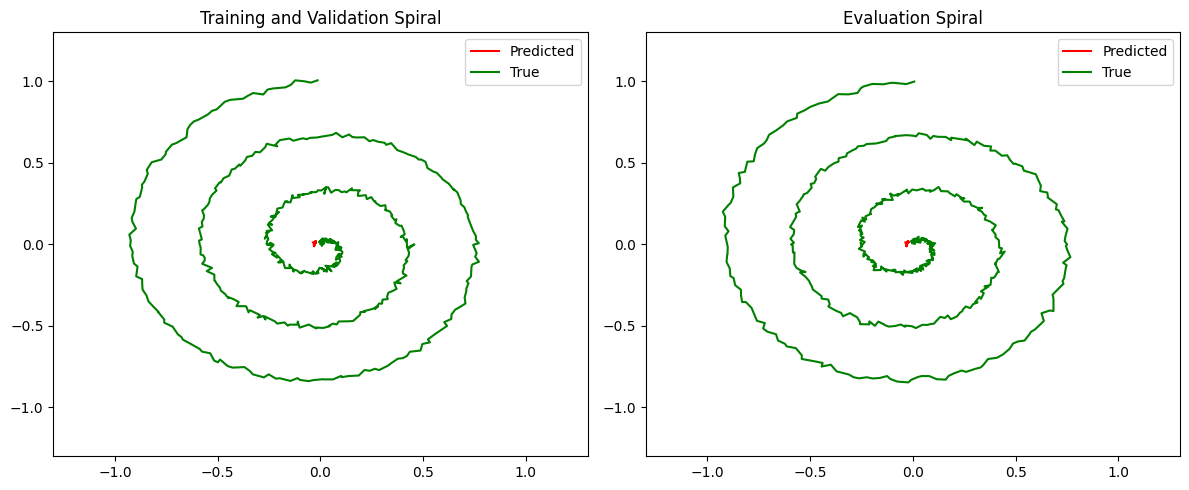

Epoch [2/2000], Average train loss: 1.007103, val loss: 0.982617, eval loss: 0.981851


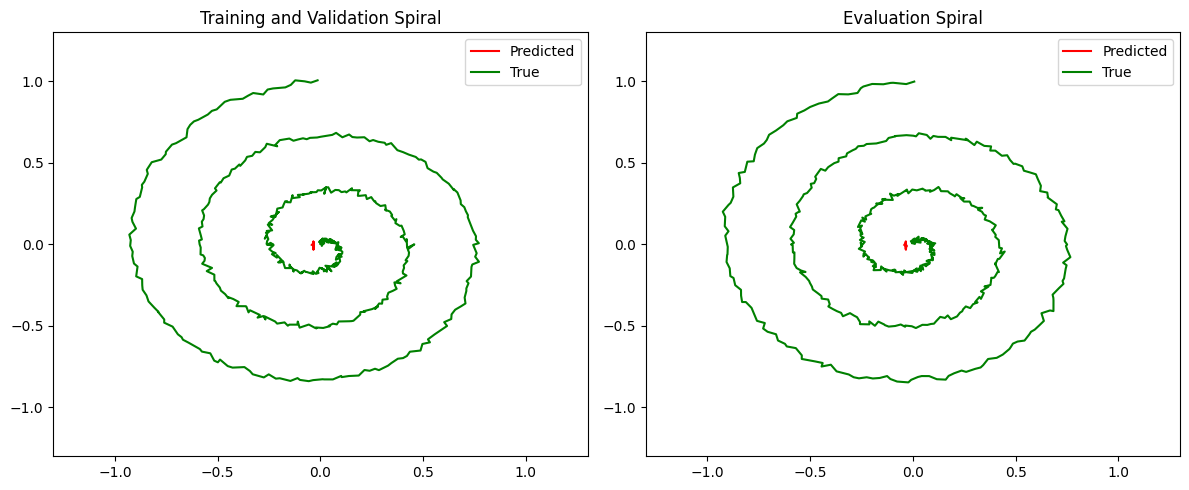

Epoch [100/2000], Average train loss: 0.003936, val loss: 0.005245, eval loss: 0.005335


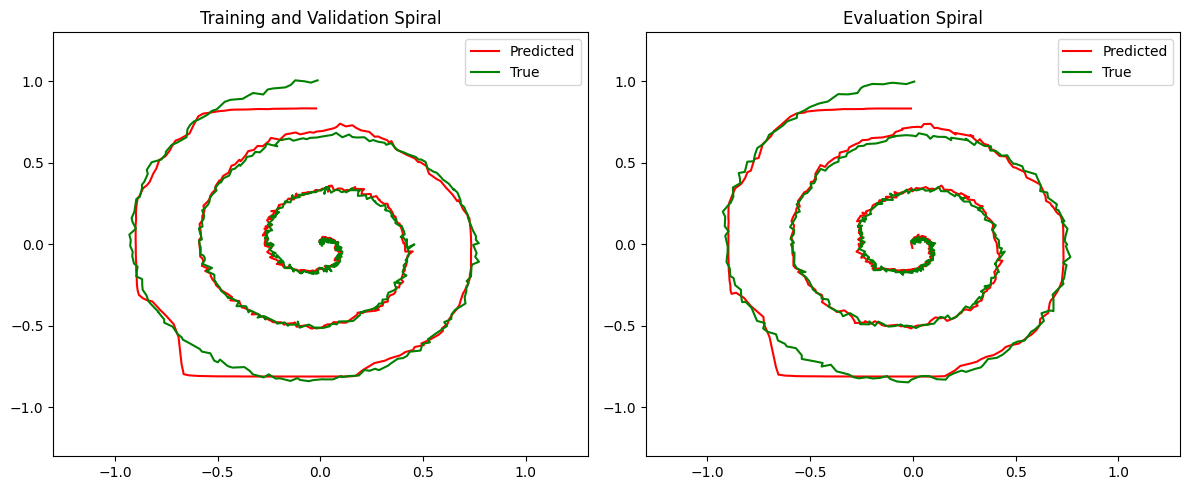

Epoch [200/2000], Average train loss: 0.001744, val loss: 0.002884, eval loss: 0.002798


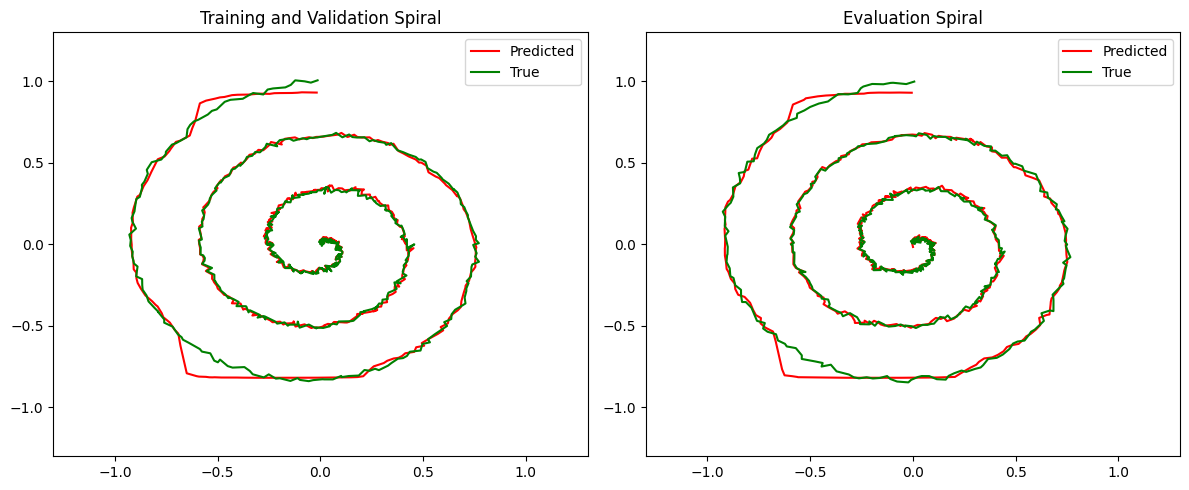

Epoch [300/2000], Average train loss: 0.001419, val loss: 0.002410, eval loss: 0.002264


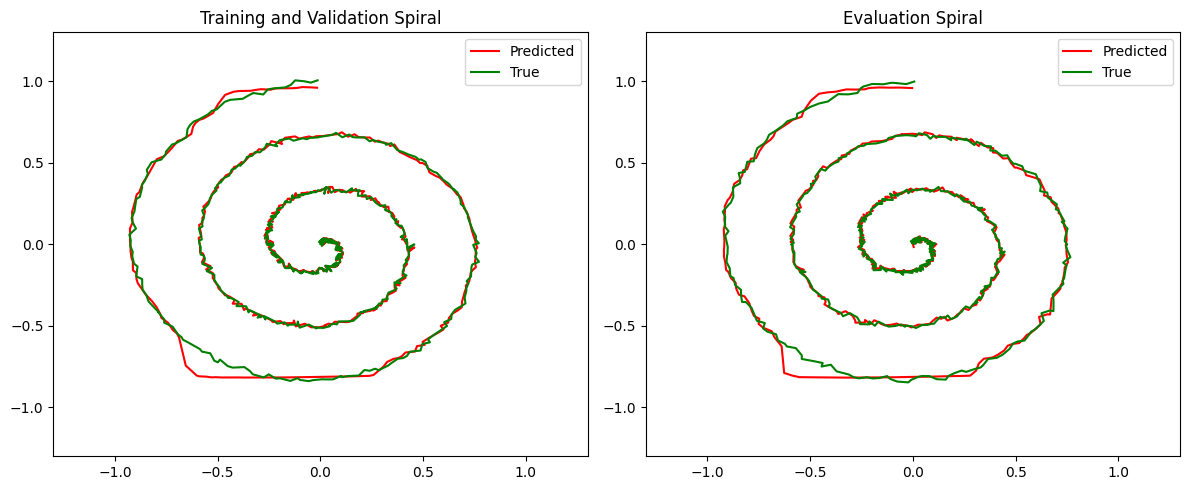

Epoch [400/2000], Average train loss: 0.001358, val loss: 0.002100, eval loss: 0.001989


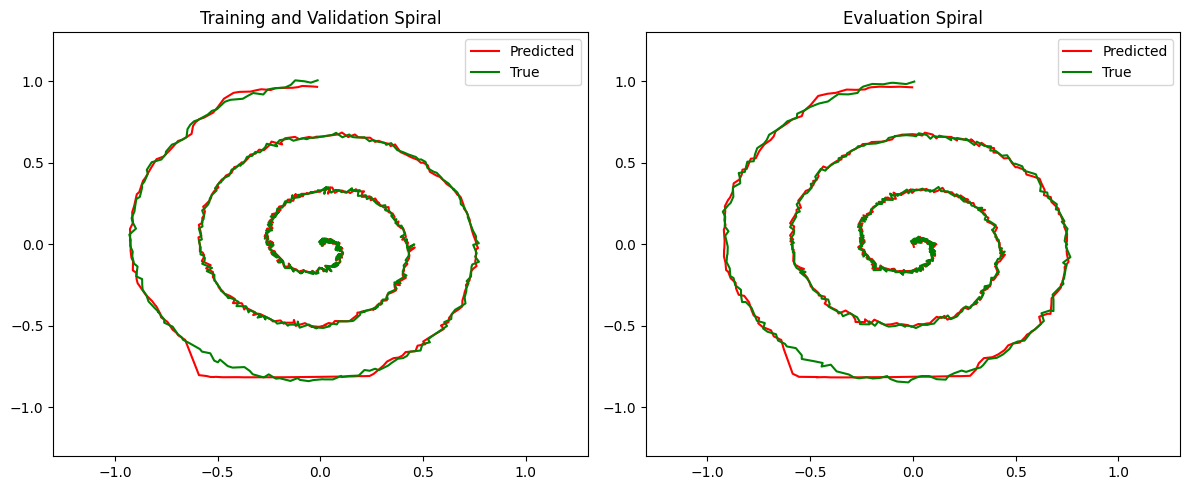

Epoch [500/2000], Average train loss: 0.001332, val loss: 0.001684, eval loss: 0.001694


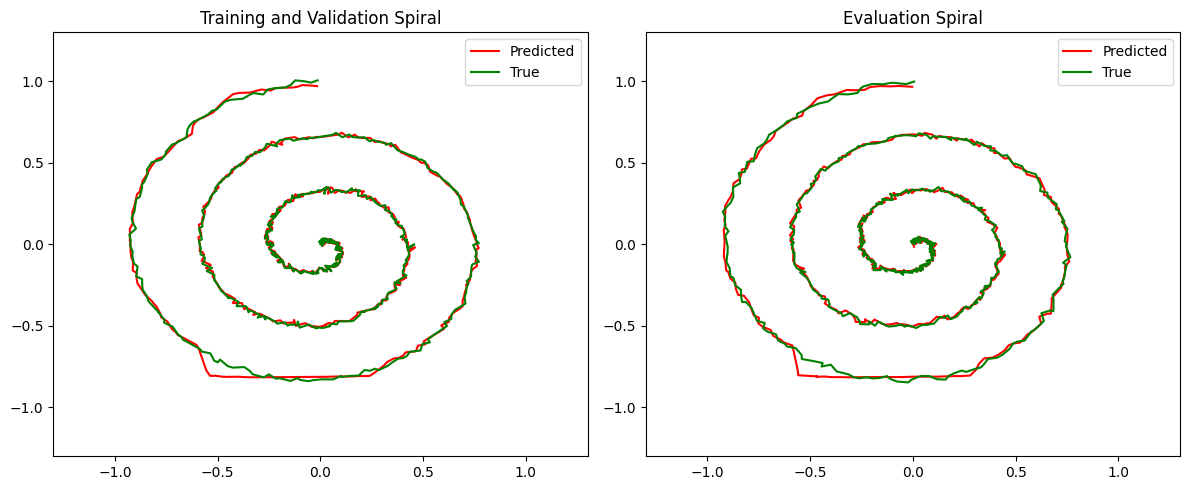

Epoch [600/2000], Average train loss: 0.001226, val loss: 0.001193, eval loss: 0.001205


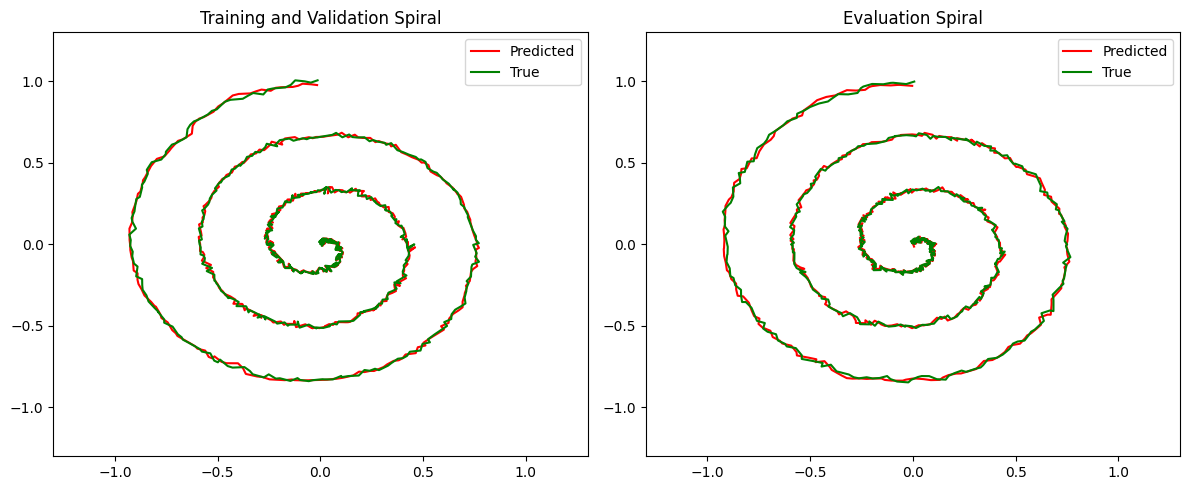

Epoch [700/2000], Average train loss: 0.001211, val loss: 0.001174, eval loss: 0.001187


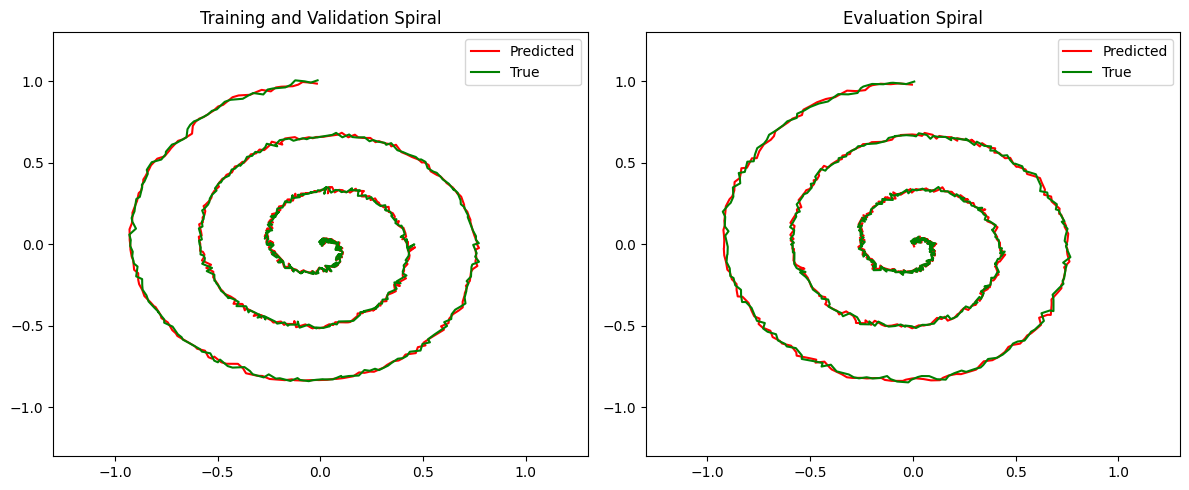

Epoch [800/2000], Average train loss: 0.001204, val loss: 0.001169, eval loss: 0.001183


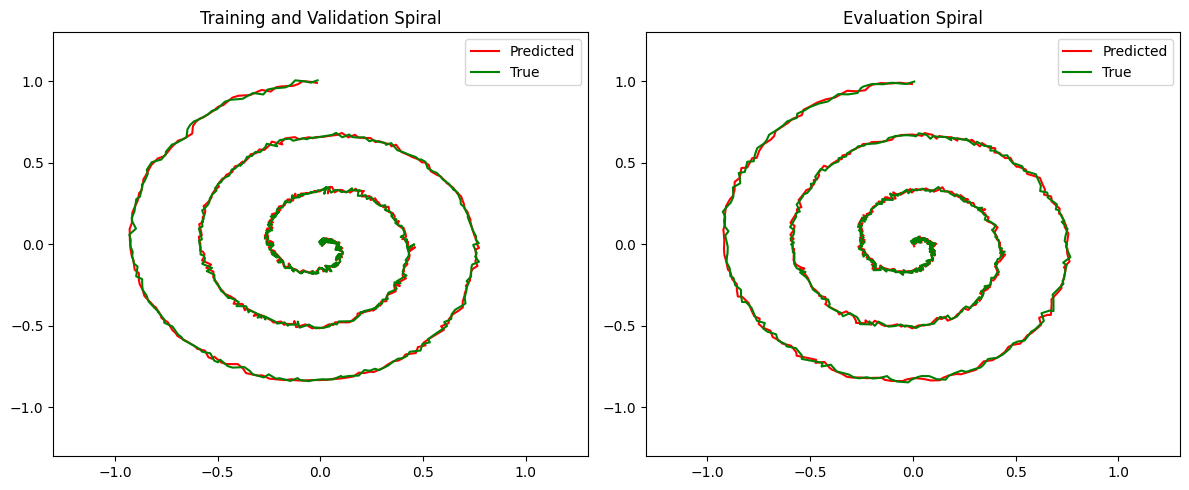

Epoch [900/2000], Average train loss: 0.001198, val loss: 0.001167, eval loss: 0.001182


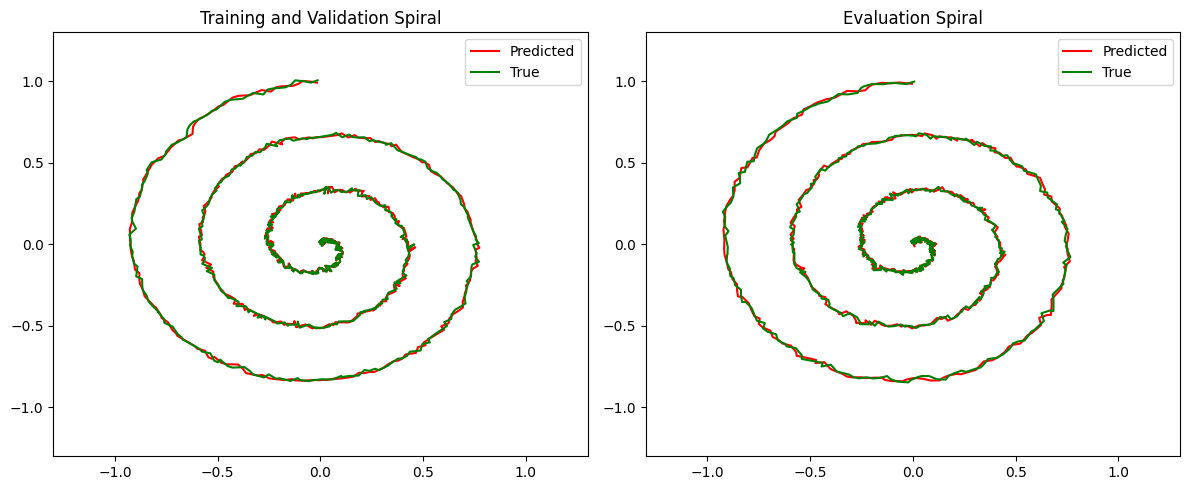

Epoch [1000/2000], Average train loss: 0.001192, val loss: 0.001164, eval loss: 0.001182


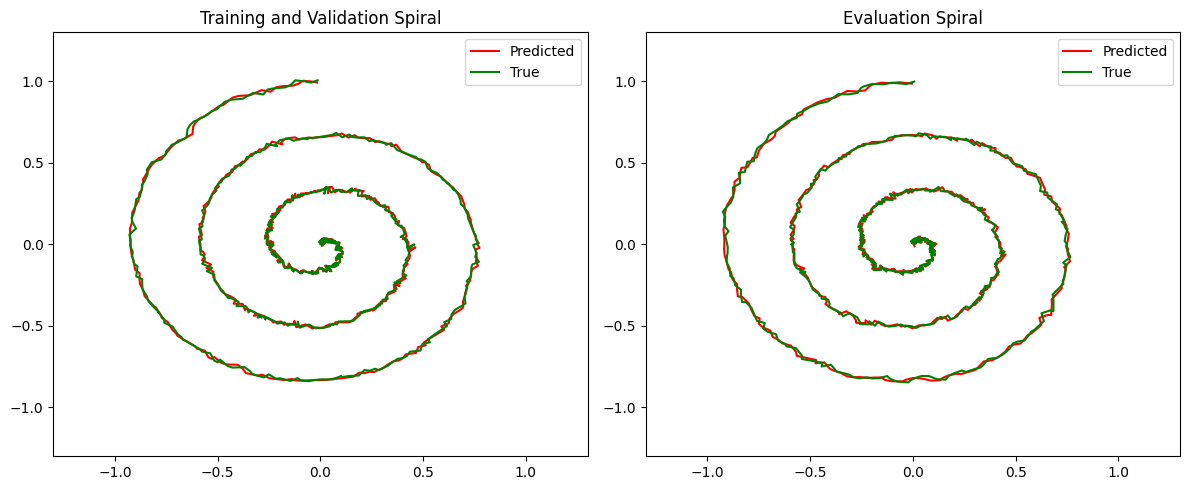

Epoch [1100/2000], Average train loss: 0.001187, val loss: 0.001159, eval loss: 0.001180


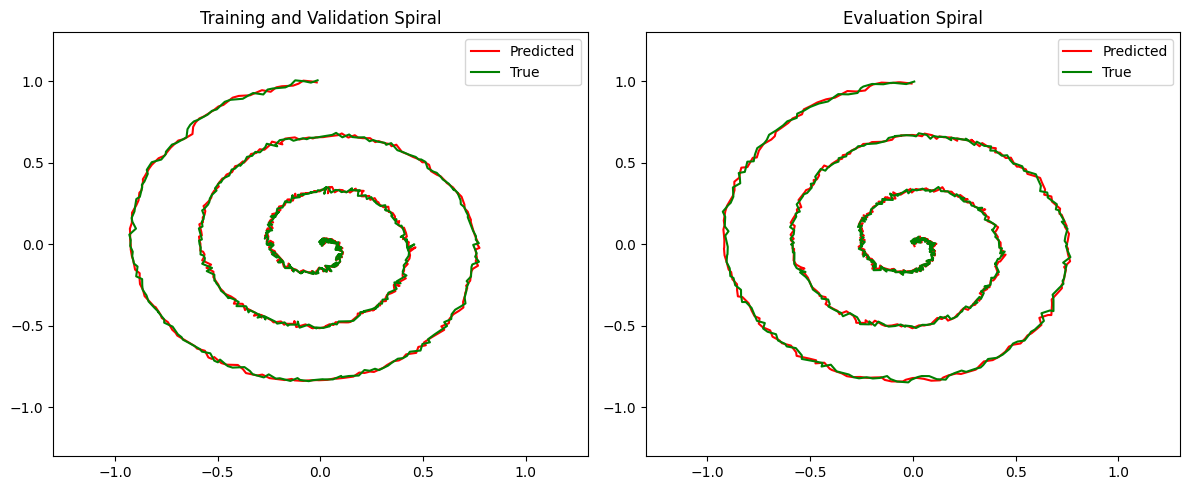

Epoch [1200/2000], Average train loss: 0.001182, val loss: 0.001154, eval loss: 0.001178


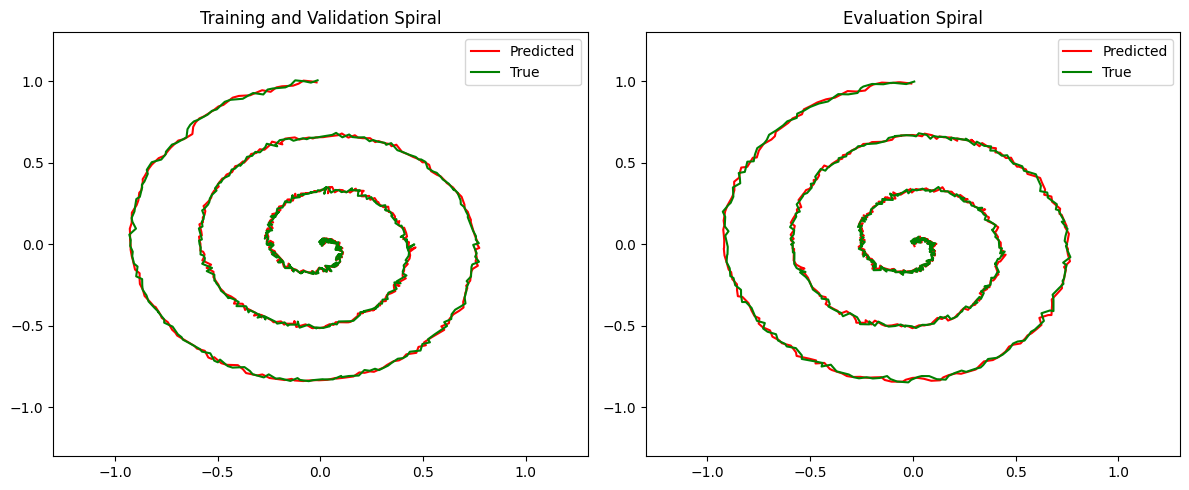

Epoch [1300/2000], Average train loss: 0.001177, val loss: 0.001152, eval loss: 0.001181


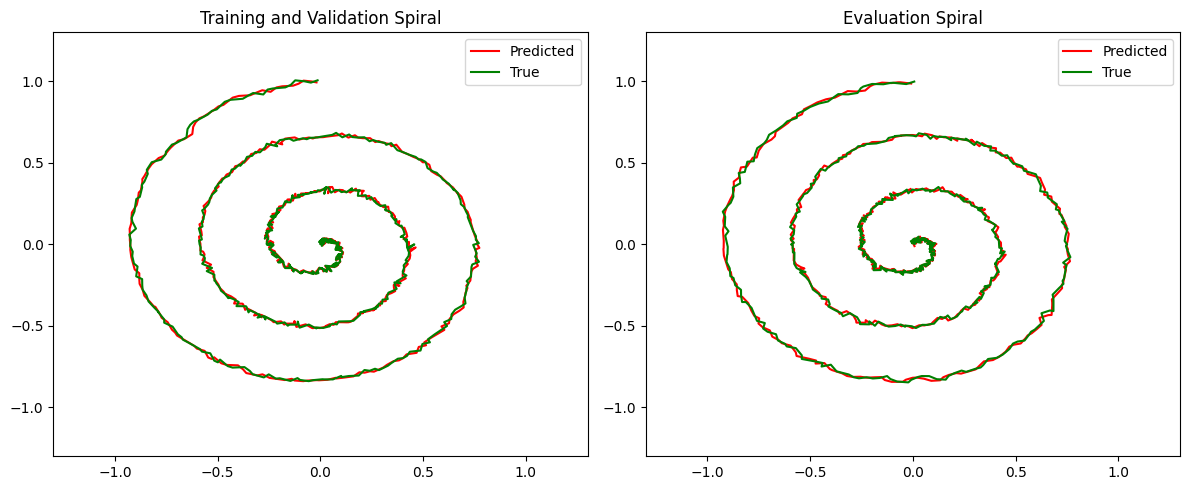

Epoch [1400/2000], Average train loss: 0.001173, val loss: 0.001137, eval loss: 0.001166


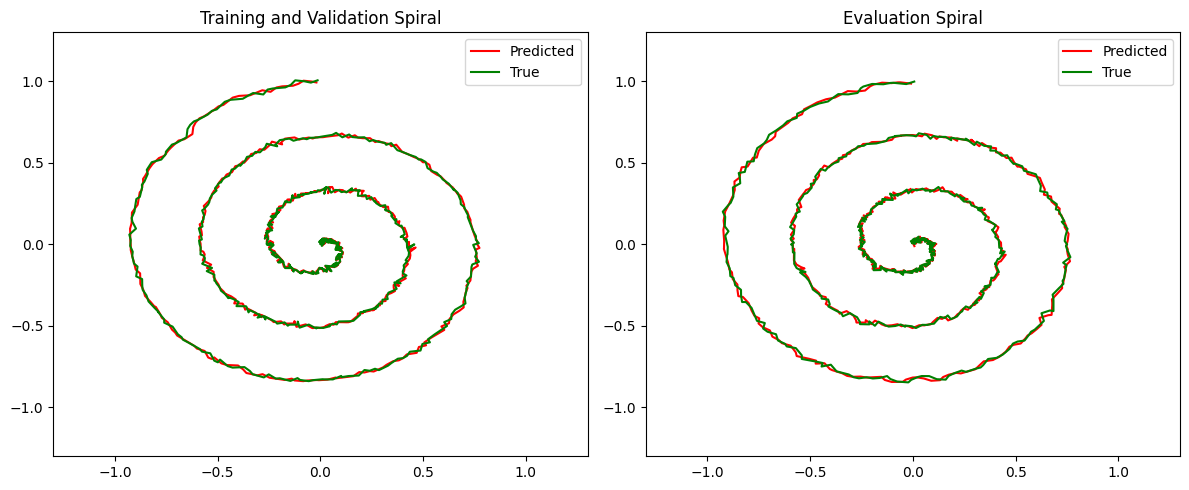

Epoch [1500/2000], Average train loss: 0.001164, val loss: 0.001132, eval loss: 0.001165


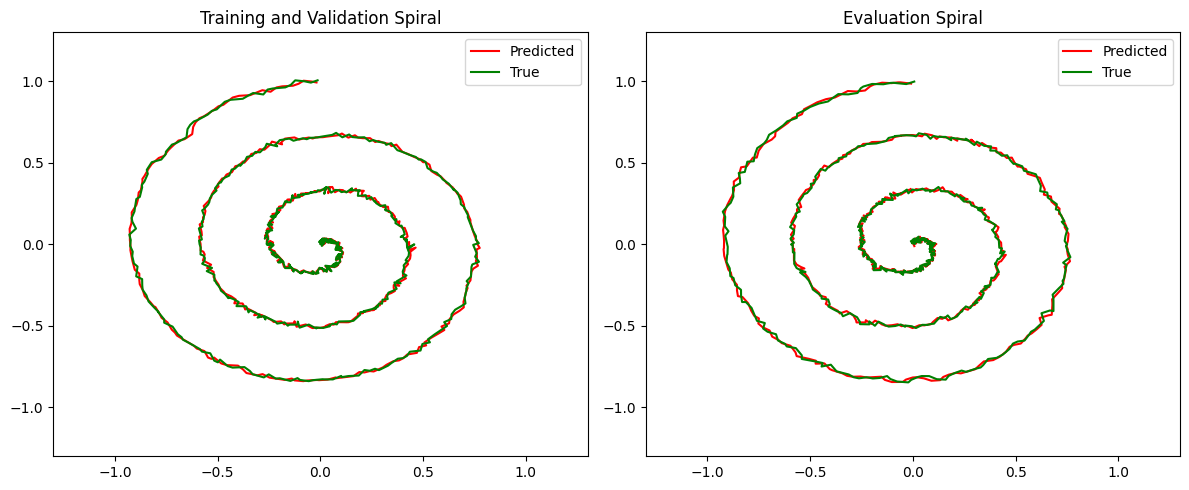

Epoch [1600/2000], Average train loss: 0.001156, val loss: 0.001123, eval loss: 0.001157


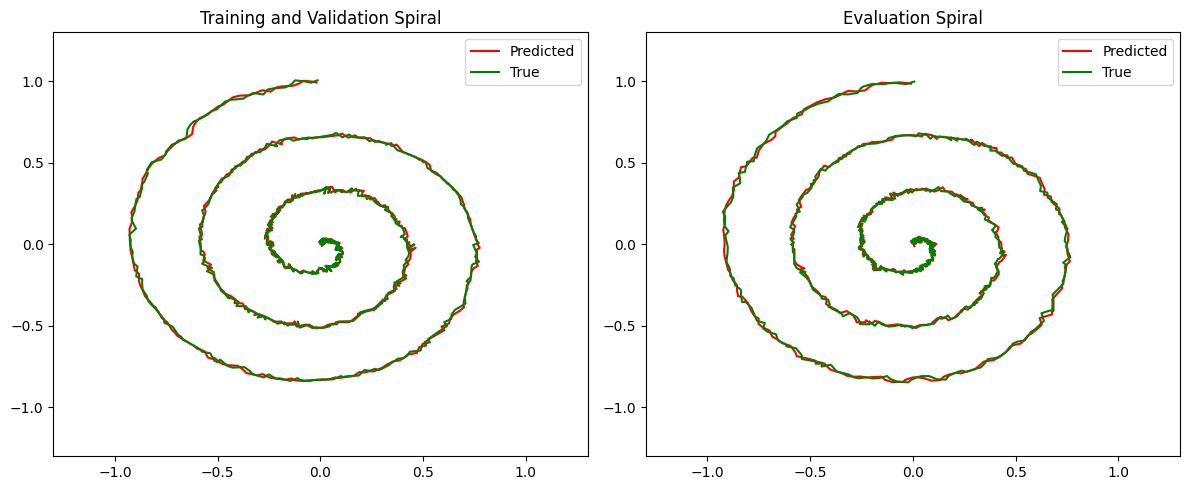

Epoch [1700/2000], Average train loss: 0.001149, val loss: 0.001115, eval loss: 0.001150


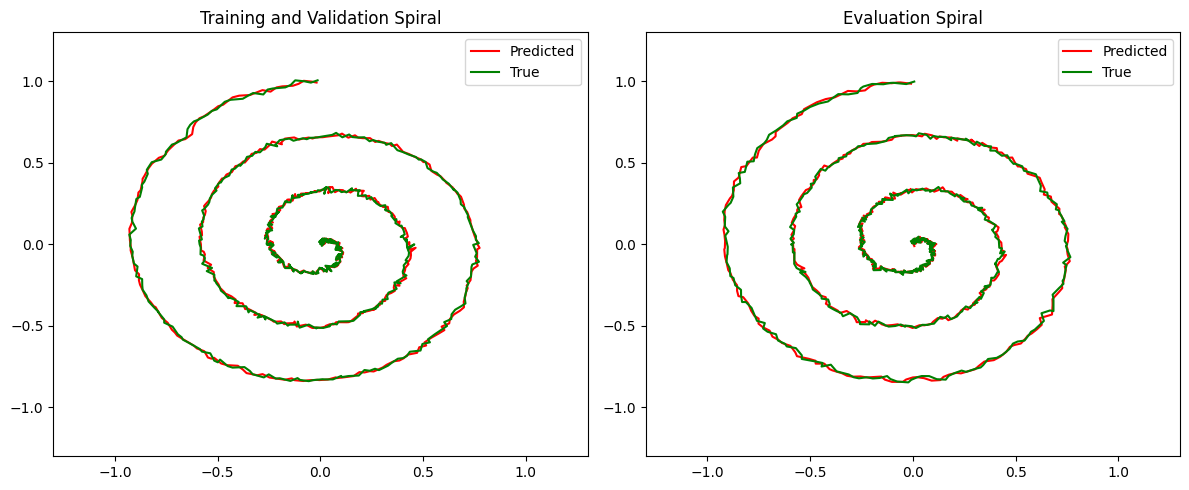

Epoch [1800/2000], Average train loss: 0.001142, val loss: 0.001113, eval loss: 0.001149


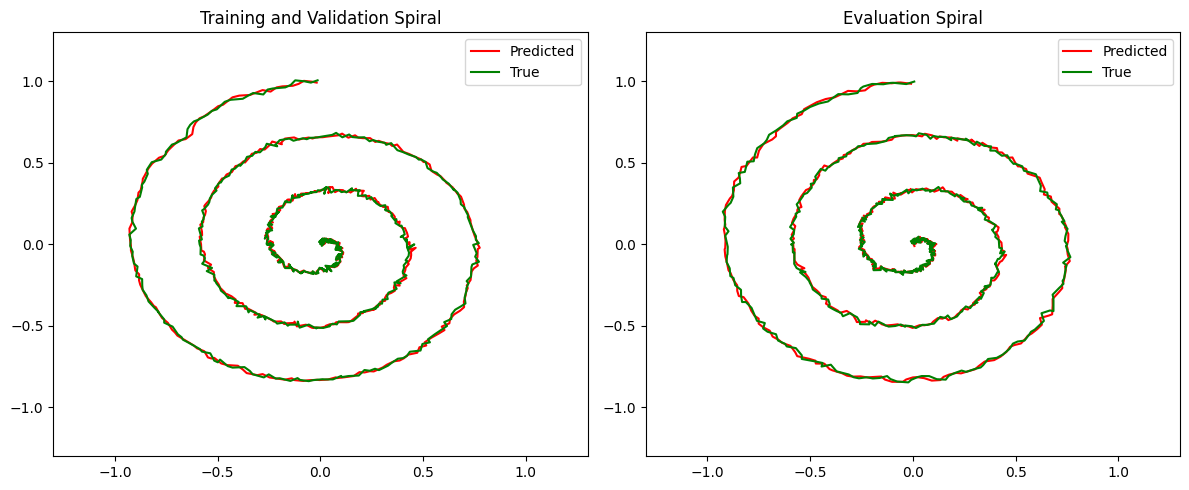

Epoch [1900/2000], Average train loss: 0.001149, val loss: 0.001178, eval loss: 0.001204


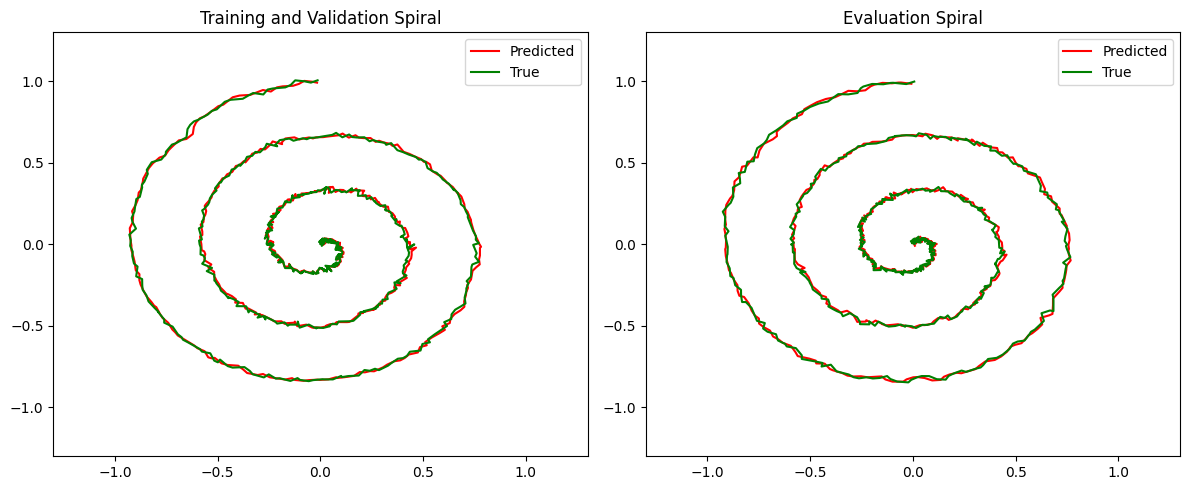

Epoch [2000/2000], Average train loss: 0.001139, val loss: 0.001073, eval loss: 0.001111


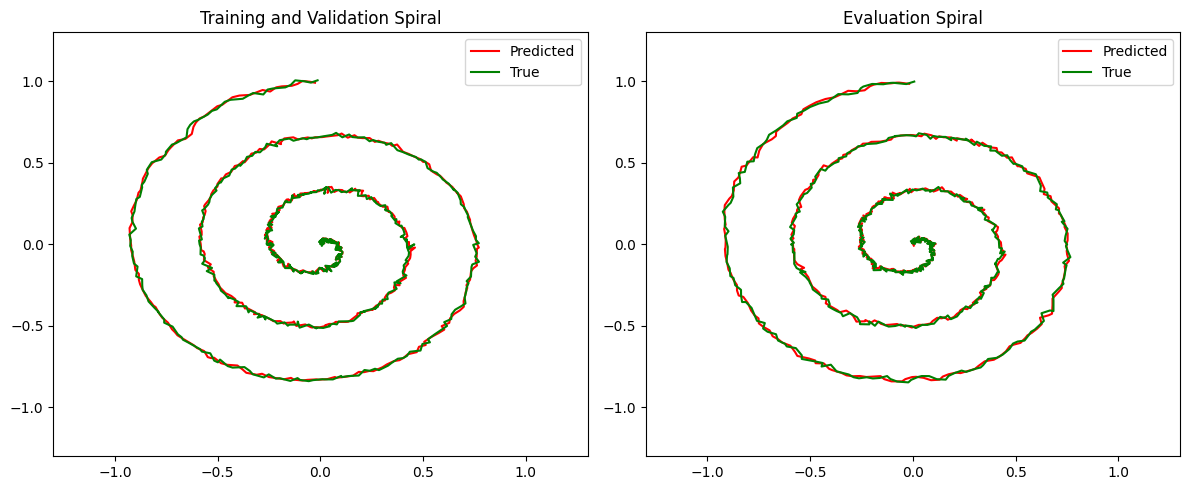

In [101]:
input_dim = 2
hidden_dim = 8 # Number of hidden dimensions (number of neurons in LIFNeuralLayer)
output_dim = 2
num_points = 500
num_turns = 3
learning_rate = 0.005
num_epochs = 2000
seq_len = 3
batch_size = 32

sample_data = generate_spiral_data(num_points, num_turns, seed=SEED)
# Normalise data (both inputs and targets)
# Note - This mean and std will be used for all normalisation/denormalisation later (during inference and adversarial attacks)
sample_data, mean, std = normalise(sample_data)
all_inputs = sample_data[:-1, :]
all_targets = sample_data[1:, :]

eval_data = generate_spiral_data(num_points, num_turns, seed=SEED + 1)
eval_data, _, _ = normalise(eval_data, mean, std)
eval_inputs = eval_data[:-1, :]
eval_targets = eval_data[1:, :]

# Denormalise targets for plotting
all_targets_denorm, _, _ = denormalise(all_targets, mean, std)
eval_targets_denorm, _, _ = denormalise(eval_targets, mean, std)

# For plotting loss curve
val_losses = []
eval_losses = []

trajectory_count = max(1, len(all_inputs) - seq_len)
train_inputs = [torch.FloatTensor(all_inputs[i:i + seq_len]) for i in range(trajectory_count)]
train_targets = [torch.FloatTensor(all_targets[i:i + seq_len]) for i in range(trajectory_count)]

random_train_indices = np.arange(len(train_inputs))
rng = np.random.default_rng(seed=SEED)
rng.shuffle(random_train_indices)
train_split_index = int(len(random_train_indices) * 0.8)
random_train_indices = random_train_indices[:train_split_index]

def create_batches(data_list, batch_size):
    return [data_list[i:i + batch_size] for i in range(0, len(data_list), batch_size)]

# Create input and target batches
train_input_batches = create_batches([train_inputs[i] for i in random_train_indices], batch_size)
train_target_batches = create_batches([train_targets[i] for i in random_train_indices], batch_size)

wiring = RandomWiring(input_dim, output_dim, hidden_dim, seed=SEED)
lnn_model = LTCRNN(wiring, input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lnn_model.parameters(), lr=learning_rate)

best_val_loss = float('inf')
best_model_state = None
patience = 200
epochs_without_improvement = 0

for epoch in range(num_epochs):
    lnn_model.train()    
    total_loss = 0

    for x, y_target in zip(train_input_batches, train_target_batches):
        optimizer.zero_grad()
        x = torch.stack(x)
        y_target = torch.stack(y_target)
        outputs = lnn_model(x)
        loss = criterion(outputs, y_target)

        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_loss / len(train_input_batches)

    lnn_model.eval()
    with torch.no_grad():
        train_and_validation_set_pred = lnn_model(torch.FloatTensor(all_inputs).unsqueeze(0))
        val_loss = criterion(train_and_validation_set_pred, torch.FloatTensor(all_targets).unsqueeze(0))
        val_losses.append(val_loss.item())
        eval_set_pred = lnn_model(torch.FloatTensor(eval_inputs).unsqueeze(0))
        eval_loss = criterion(eval_set_pred, torch.FloatTensor(eval_targets).unsqueeze(0))
        eval_losses.append(eval_loss.item())

    # Evaluation and plotting every 100 epochs (as well as the first two epochs)
    if (epoch + 1) % 100 == 0 or epoch == 0 or epoch == 1:
        with torch.no_grad():
            eval_set_pred = lnn_model(torch.FloatTensor(eval_inputs).unsqueeze(0))
            eval_loss = criterion(eval_set_pred, torch.FloatTensor(eval_targets).unsqueeze(0))

        print(f'Epoch [{epoch+1}/{num_epochs}], Average train loss: {avg_train_loss:.6f}, val loss: {val_loss:.6f}, eval loss: {eval_loss:.6f}')

        if val_loss.item() < best_val_loss - 1e-6:
            best_val_loss = val_loss.item()
            best_model_state = lnn_model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 100
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best val loss: {best_val_loss:.6f}")
            lnn_model.load_state_dict(best_model_state)
            break
            
        # Denormalise and plot
        train_pred_denorm, _, _ = denormalise(train_and_validation_set_pred.squeeze(0).numpy(), mean, std)
        eval_pred_denorm, _, _ = denormalise(eval_set_pred.squeeze(0).numpy(), mean, std)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        axes[0].plot(train_pred_denorm[:, 0], train_pred_denorm[:, 1], 'r-', label='Predicted')
        axes[0].plot(all_targets_denorm[:, 0], all_targets_denorm[:, 1], 'g-', label='True')
        axes[0].set_title("Training and Validation Spiral")
        axes[0].set_xlim(-1.3, 1.3)
        axes[0].set_ylim(-1.3, 1.3)
        axes[0].legend()

        axes[1].plot(eval_pred_denorm[:, 0], eval_pred_denorm[:, 1], 'r-', label='Predicted')
        axes[1].plot(eval_targets_denorm[:, 0], eval_targets_denorm[:, 1], 'g-', label='True')
        axes[1].set_title("Evaluation Spiral")
        axes[1].set_xlim(-1.3, 1.3)
        axes[1].set_ylim(-1.3, 1.3)
        axes[1].legend()

        plt.tight_layout()
        plt.show()

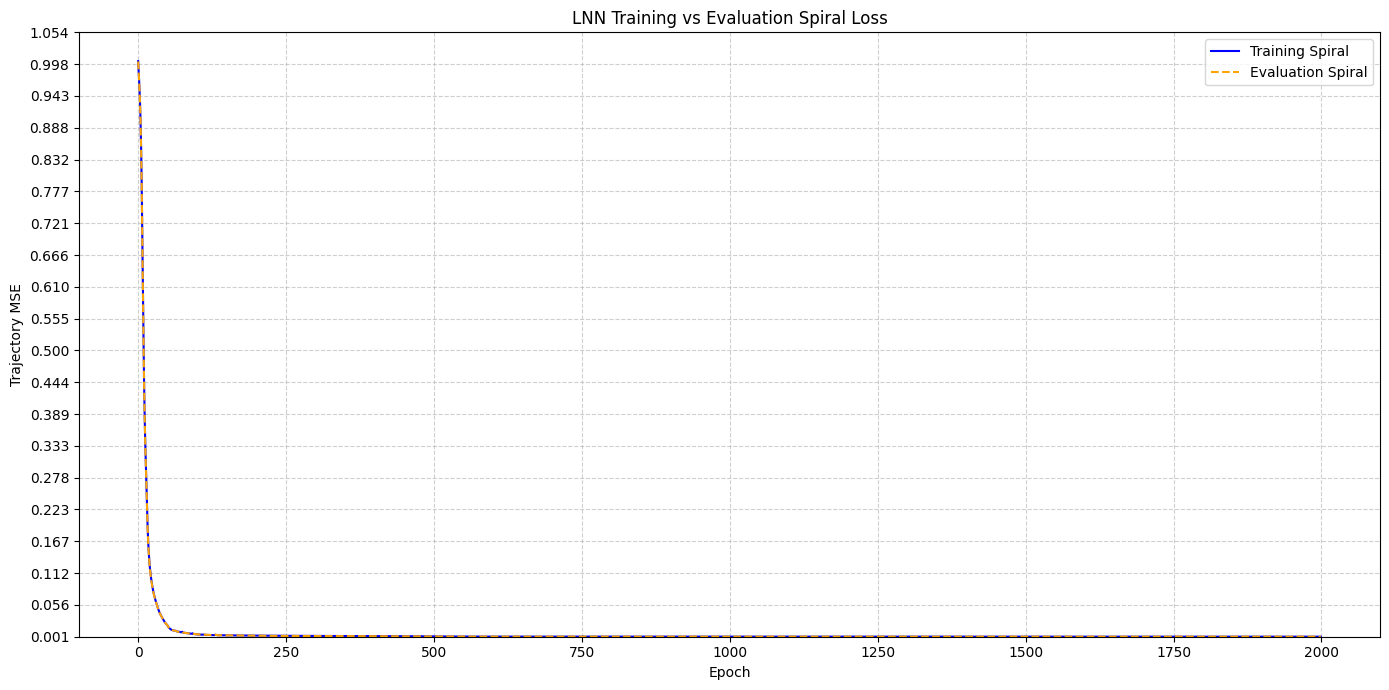

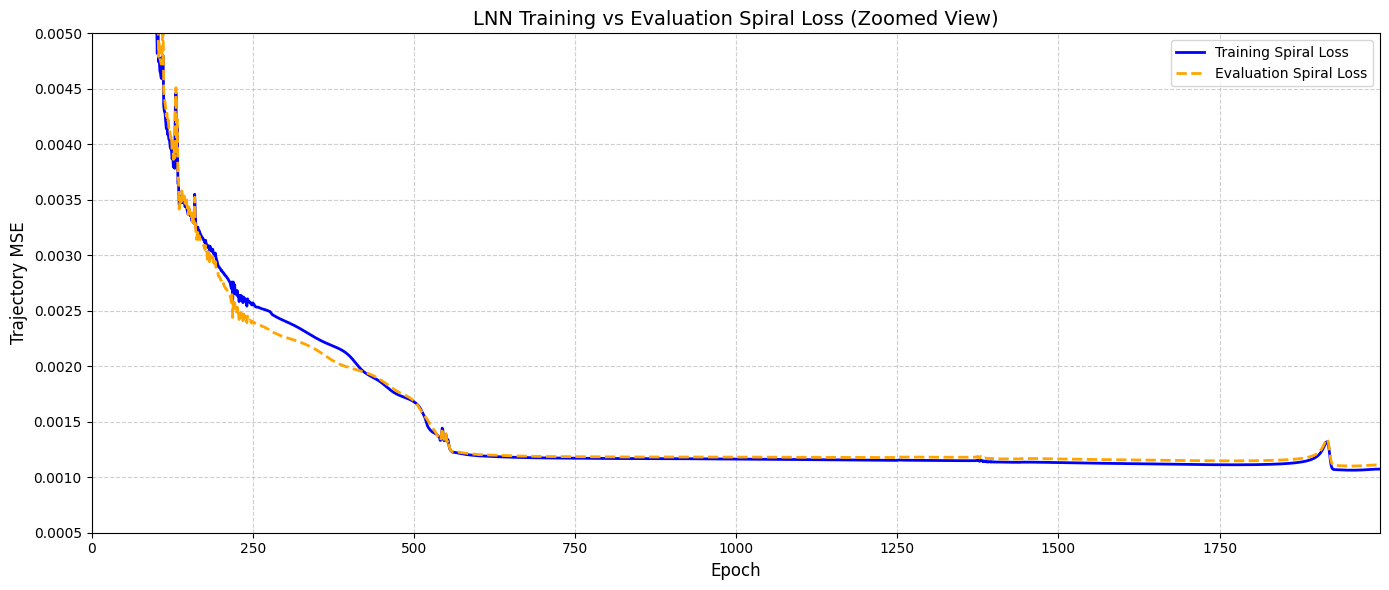

In [109]:
# Plotting loss curves for LNN training

plt.figure(figsize=(14, 7))

epochs = np.arange(len(val_losses)) 
plt.plot(epochs, val_losses, label='Training Spiral', color='blue')
plt.plot(epochs, eval_losses, label='Evaluation Spiral', color='orange', linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Trajectory MSE")
plt.title("LNN Training vs Evaluation Spiral Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

ymin = min(min(val_losses), min(eval_losses))
ymax = max(max(val_losses), max(eval_losses))
plt.ylim([ymin * 0.95, ymax * 1.05])
plt.yticks(np.linspace(ymin * 0.95, ymax * 1.05, num=20))

plt.tight_layout()
plt.show()



plt.figure(figsize=(14, 6))

epochs = np.arange(len(val_losses))

plt.plot(epochs, val_losses, label='Training Spiral Loss', color='blue', linewidth=2)
plt.plot(epochs, eval_losses, label='Evaluation Spiral Loss', color='orange', linewidth=2, linestyle='--')

plt.xlim(0, len(val_losses) - 1)
# Add zoom to final region
plt.ylim(0.0005, 0.005)

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Trajectory MSE", fontsize=12)
plt.title("LNN Training vs Evaluation Spiral Loss (Zoomed View)", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [110]:
torch.save(lnn_model, "lnn_model.pt")

In [91]:
lnn_model = torch.load("lnn_model.pt", weights_only=False)

# TCN Model

A Temporal Convolutional Network (TCN) is a sequence modeling architecture that uses 1D causal and dilated convolutions to process inputs in temporal order, enabling it to capture long-range dependencies efficiently while preserving causality and leveraging residual connections for stable training.

To compare adversarial robustness of TCN against LNN (by running the same adversarial attacks on TCN)

In [92]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super(ResidualBlock, self).__init__()
        padding = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.dropout = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.conv1(x))[:, :, :-self.conv1.padding[0]]
        out = self.dropout(out)
        out = self.relu(self.conv2(out))[:, :, :-self.conv2.padding[0]]
        out = self.dropout(out)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_dim=2, hidden_channels=128, output_dim=2, num_layers=3, kernel_size=3, dropout=0.3):
        super(TCN, self).__init__()
        layers = []
        for i in range(num_layers):
            dilation = 2 ** i
            in_ch = input_dim if i == 0 else hidden_channels
            layers.append(ResidualBlock(in_ch, hidden_channels, kernel_size, dilation, dropout))
        self.tcn = nn.Sequential(*layers)
        self.output_layer = nn.Conv1d(hidden_channels, output_dim, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.tcn(x)
        x = self.output_layer(x)
        return x.permute(0, 2, 1)

Epoch [1/1000], Total train loss: 1.352537, val loss: 0.012137, eval loss: 0.012126


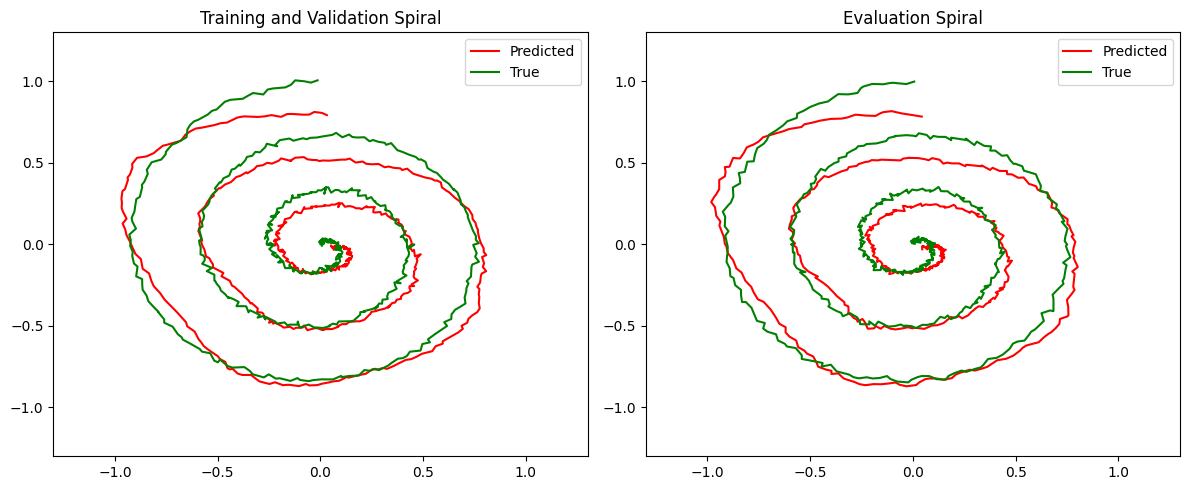

Epoch [2/1000], Total train loss: 0.150656, val loss: 0.010004, eval loss: 0.010017


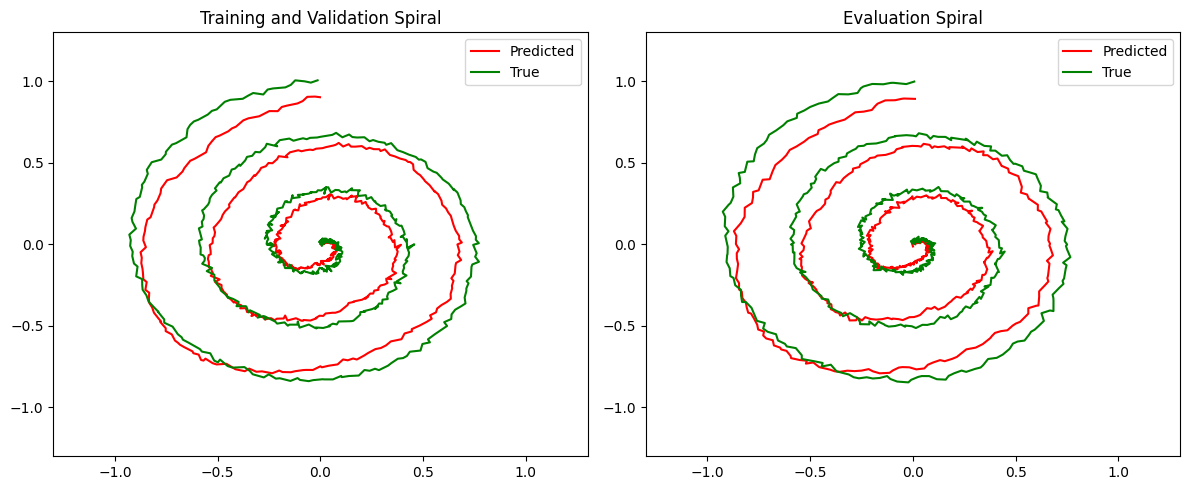

Epoch [100/1000], Total train loss: 0.007776, val loss: 0.000625, eval loss: 0.000636


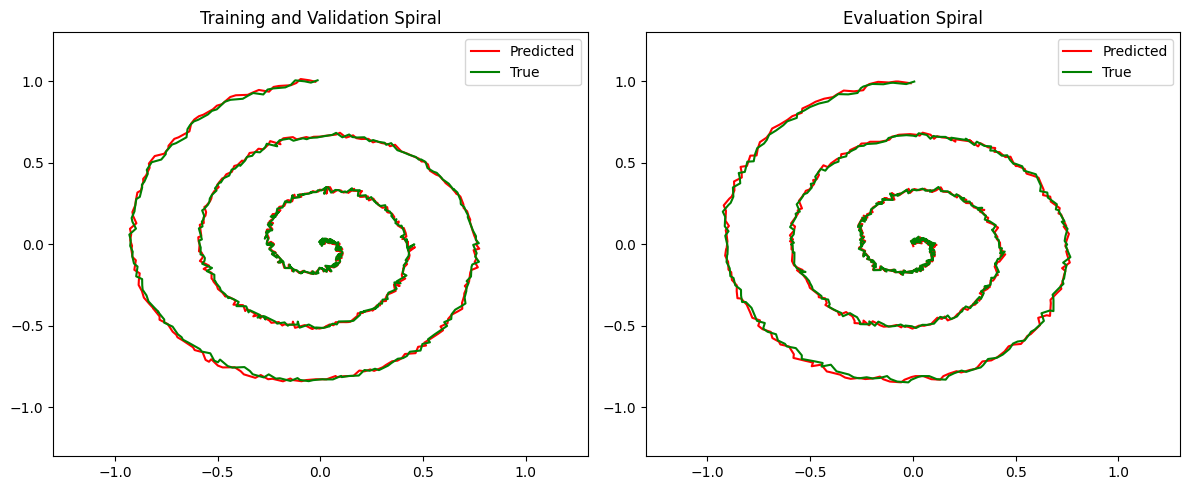

Epoch [200/1000], Total train loss: 0.007512, val loss: 0.000605, eval loss: 0.000619


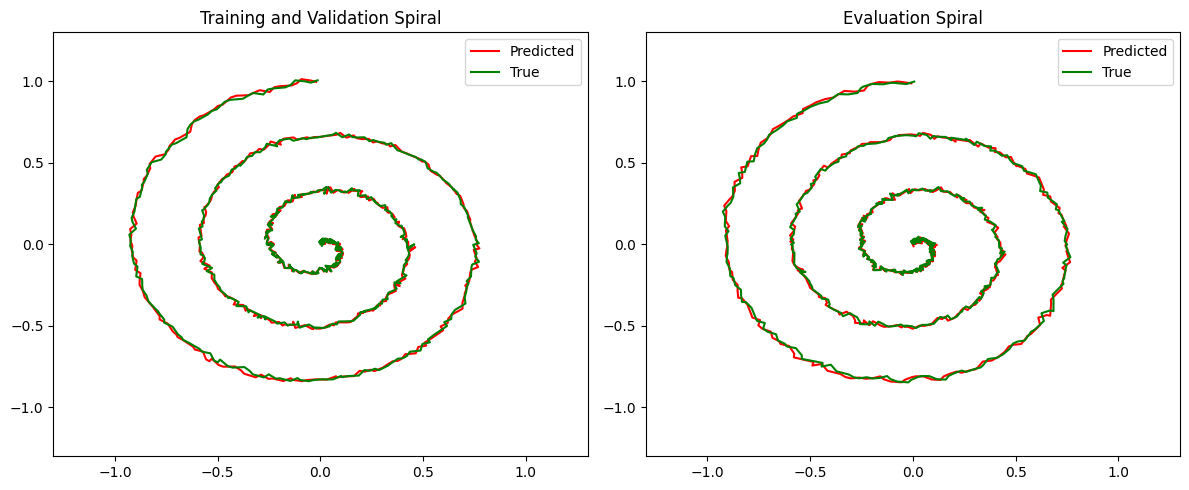

Epoch [300/1000], Total train loss: 0.007449, val loss: 0.000602, eval loss: 0.000617


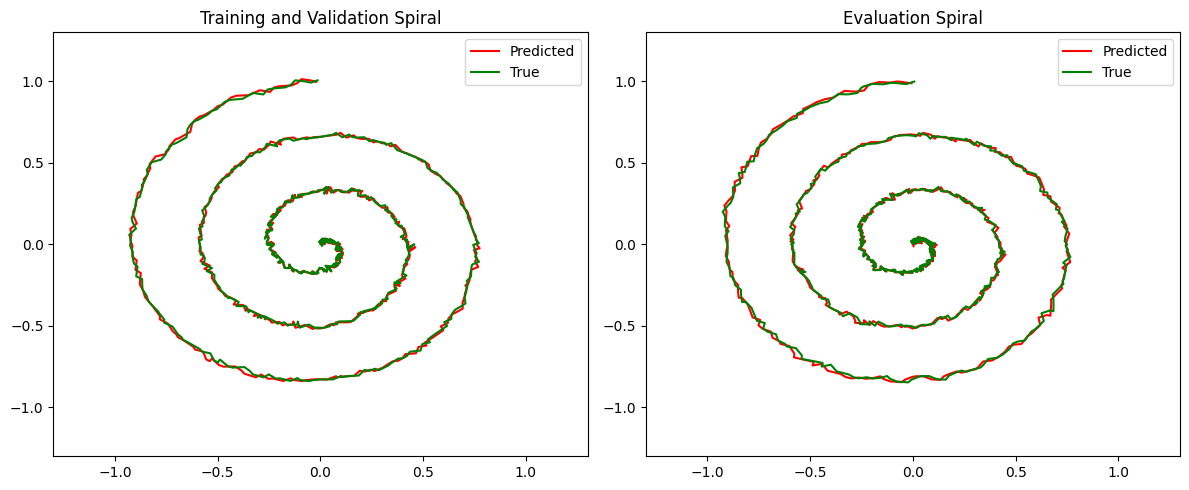

Epoch [400/1000], Total train loss: 0.007480, val loss: 0.000602, eval loss: 0.000617


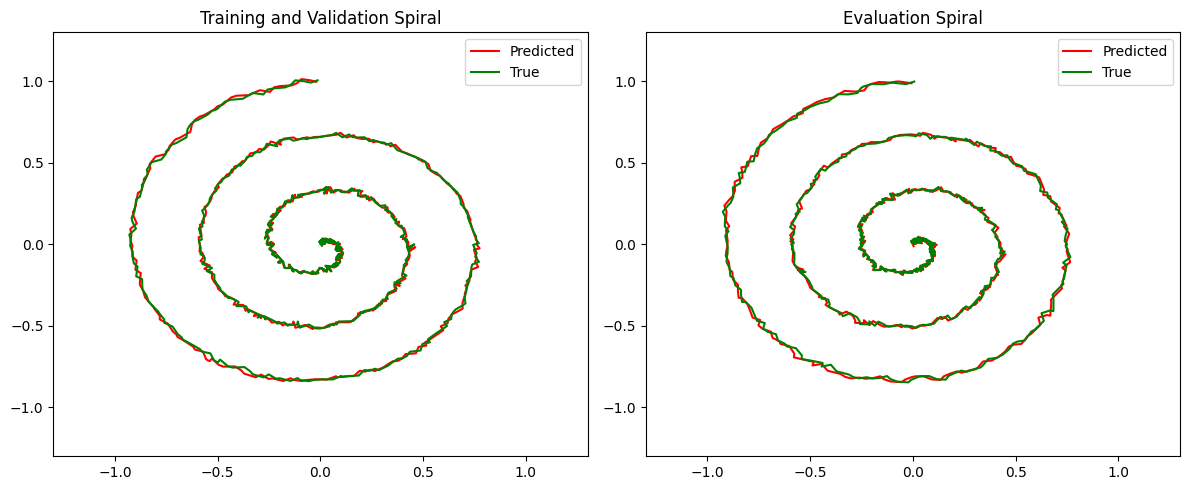

Epoch [500/1000], Total train loss: 0.007459, val loss: 0.000602, eval loss: 0.000616
Early stopping triggered at epoch 500. Best val loss: 0.000602


In [61]:
learning_rate = 0.005
num_epochs = 1000
seq_len = 3
batch_size = 32

# Use the same normalised data from before (sample_data)
# sample_data
all_inputs = sample_data[:-1, :]
all_targets = sample_data[1:, :]
eval_inputs = eval_data[:-1, :]
eval_targets = eval_data[1:, :]

# Denormalise targets for plotting
all_targets_denorm, _, _ = denormalise(all_targets, mean, std)
eval_targets_denorm, _, _ = denormalise(eval_targets, mean, std)

trajectory_count = max(1, len(all_inputs) - seq_len)
train_inputs = [torch.FloatTensor(all_inputs[i:i + seq_len]) for i in range(trajectory_count)]
train_targets = [torch.FloatTensor(all_targets[i:i + seq_len]) for i in range(trajectory_count)]

random_train_indices = np.arange(len(train_inputs))
# np.random.shuffle(random_train_indices)
rng = np.random.default_rng(seed=SEED)
rng.shuffle(random_train_indices)
train_split_index = int(len(random_train_indices) * 0.8)
random_train_indices = random_train_indices[:train_split_index]

train_input_batches = [train_inputs[i] for i in random_train_indices]
train_target_batches = [train_targets[i] for i in random_train_indices]

def create_batches(data_list, batch_size):
    return [data_list[i:i + batch_size] for i in range(0, len(data_list), batch_size)]

train_input_batches = create_batches([train_inputs[i] for i in random_train_indices], batch_size)
train_target_batches = create_batches([train_targets[i] for i in random_train_indices], batch_size)

tcn_model = TCN()

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(tcn_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

best_val_loss = float('inf')
best_model_state = None
patience = 200
epochs_without_improvement = 0

for epoch in range(num_epochs):
    tcn_model.train()
    total_loss = 0

    for x_batch, y_batch in zip(train_input_batches, train_target_batches):
        x = torch.stack(x_batch)
        y = torch.stack(y_batch)

        optimizer.zero_grad()
        outputs = tcn_model(x)
        loss = criterion(outputs, y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    # Evaluation and plotting every 100 epochs (as well as the first two epochs)
    if (epoch + 1) % 100 == 0 or epoch == 0 or epoch == 1:
        tcn_model.eval()
        with torch.no_grad():
            train_and_validation_set_pred = tcn_model(torch.FloatTensor(all_inputs).unsqueeze(0))
            eval_set_pred = tcn_model(torch.FloatTensor(eval_inputs).unsqueeze(0))
            val_loss = criterion(train_and_validation_set_pred, torch.FloatTensor(all_targets).unsqueeze(0))
            eval_loss = criterion(eval_set_pred, torch.FloatTensor(eval_targets).unsqueeze(0))

        print(f'Epoch [{epoch+1}/{num_epochs}], Total train loss: {total_loss:.6f}, val loss: {val_loss:.6f}, eval loss: {eval_loss:.6f}')

        if val_loss.item() < best_val_loss - 1e-6:
            best_val_loss = val_loss.item()
            best_model_state = tcn_model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 100
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best val loss: {best_val_loss:.6f}")
            tcn_model.load_state_dict(best_model_state)
            break
            
        # Denormalise and plot
        train_pred_denorm, _, _ = denormalise(train_and_validation_set_pred.squeeze(0).numpy(), mean, std)
        eval_pred_denorm, _, _ = denormalise(eval_set_pred.squeeze(0).numpy(), mean, std)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        axes[0].plot(train_pred_denorm[:, 0], train_pred_denorm[:, 1], 'r-', label='Predicted')
        axes[0].plot(all_targets_denorm[:, 0], all_targets_denorm[:, 1], 'g-', label='True')
        axes[0].set_title("Training and Validation Spiral")
        axes[0].set_xlim(-1.3, 1.3)
        axes[0].set_ylim(-1.3, 1.3)
        axes[0].legend()

        axes[1].plot(eval_pred_denorm[:, 0], eval_pred_denorm[:, 1], 'r-', label='Predicted')
        axes[1].plot(eval_targets_denorm[:, 0], eval_targets_denorm[:, 1], 'g-', label='True')
        axes[1].set_title("Evaluation Spiral")
        axes[1].set_xlim(-1.3, 1.3)
        axes[1].set_ylim(-1.3, 1.3)
        axes[1].legend()

        plt.tight_layout()
        plt.show()

In [15]:
torch.save(tcn_model, "tcn_model.pt")

In [93]:
tcn_model = torch.load("tcn_model.pt", weights_only=False)

# LSTM Model

In [94]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=160, num_layers=2, output_dim=2, dropout=0.1):
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )
        
        self.norm = nn.LayerNorm(hidden_dim)

        self.residual_proj = nn.Linear(input_dim, hidden_dim) 
        
        self.mlp_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        # x: [batch, seq_len, input_dim]
        lstm_out, _ = self.lstm(x) 
        res = self.residual_proj(x)
        out = self.norm(lstm_out + res)
        return self.mlp_head(out)

Epoch [1/1000], Total train loss: 5.081653, val loss: 0.133111, eval loss: 0.131972


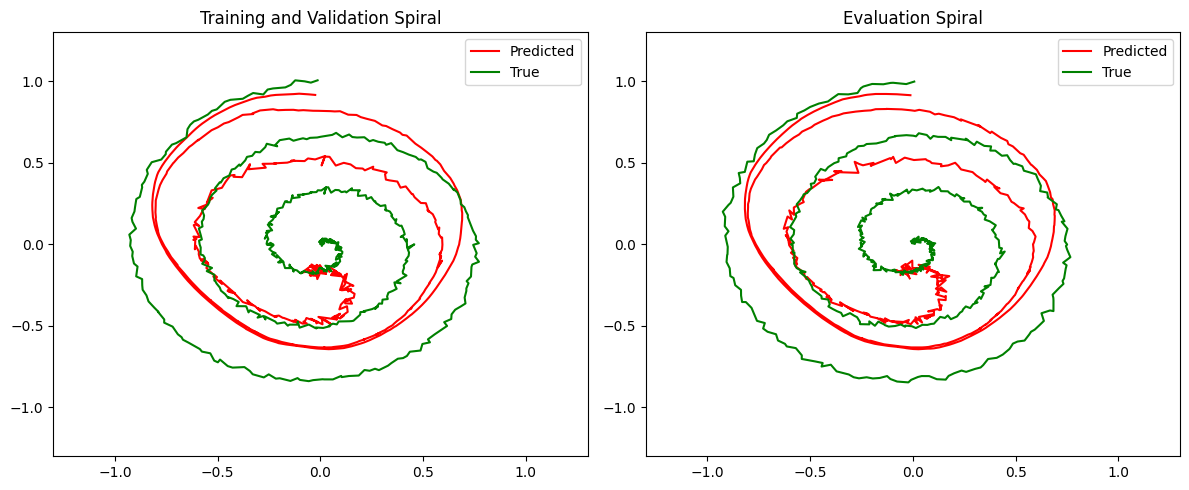

Epoch [2/1000], Total train loss: 1.377741, val loss: 0.092607, eval loss: 0.092187


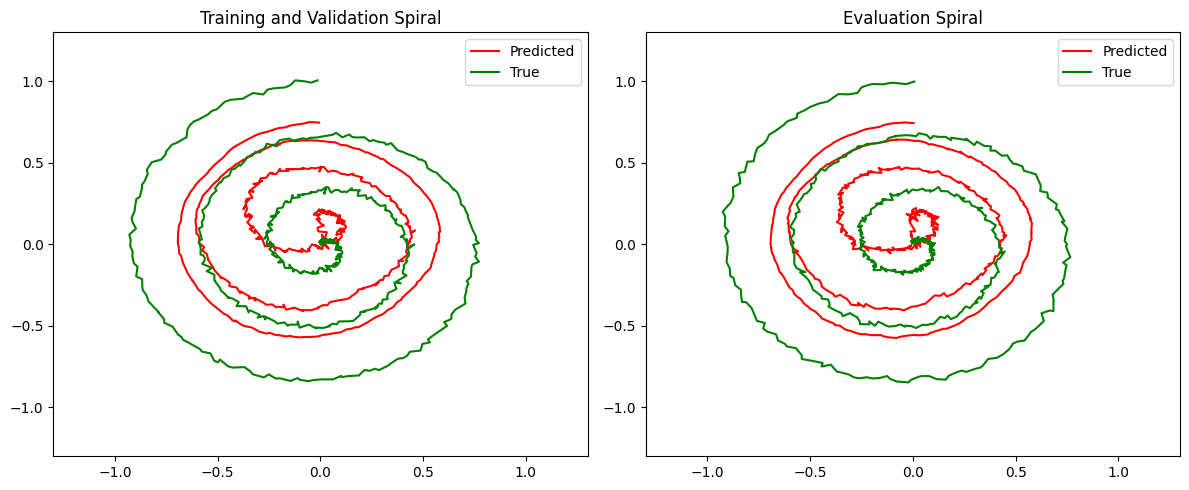

Epoch [100/1000], Total train loss: 0.123381, val loss: 0.004203, eval loss: 0.004152


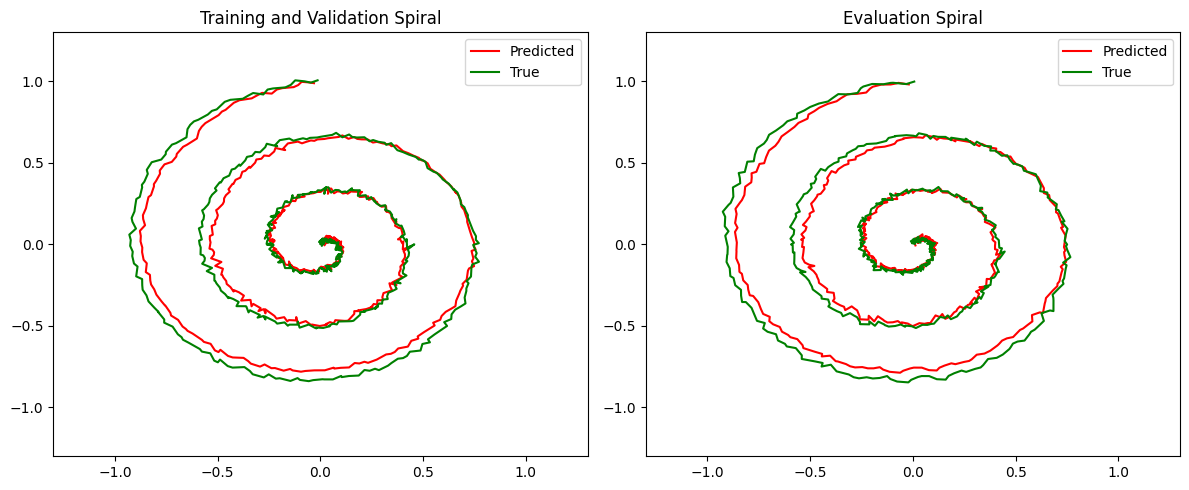

Epoch [200/1000], Total train loss: 0.123486, val loss: 0.005706, eval loss: 0.005642


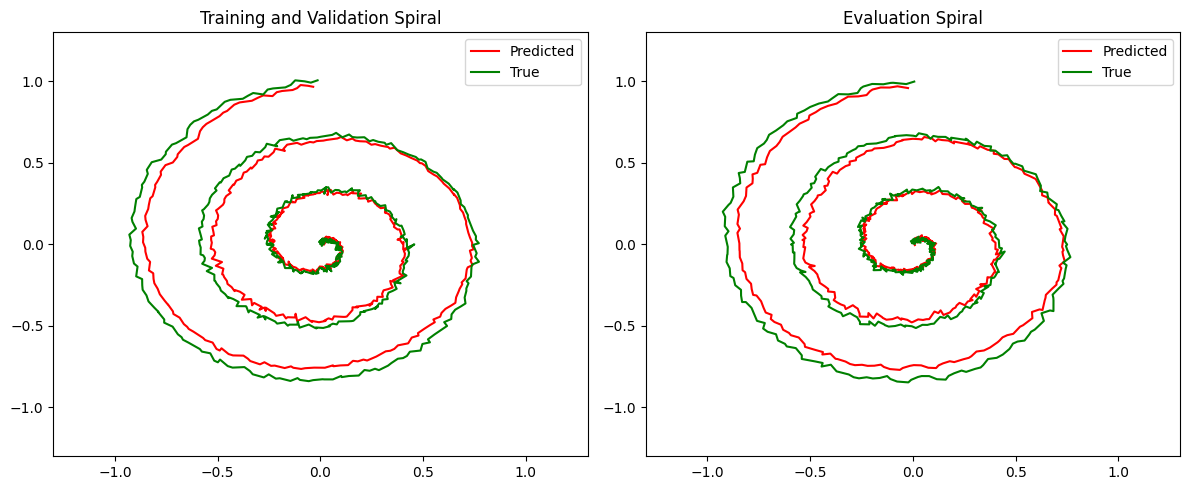

Epoch [300/1000], Total train loss: 0.113791, val loss: 0.005317, eval loss: 0.005265


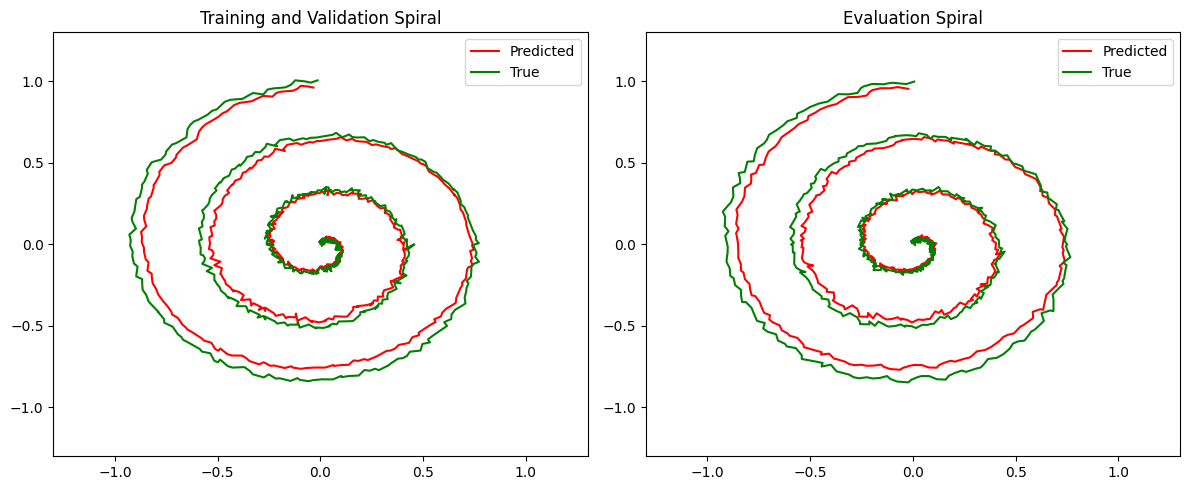

Epoch [400/1000], Total train loss: 0.108690, val loss: 0.005108, eval loss: 0.005052


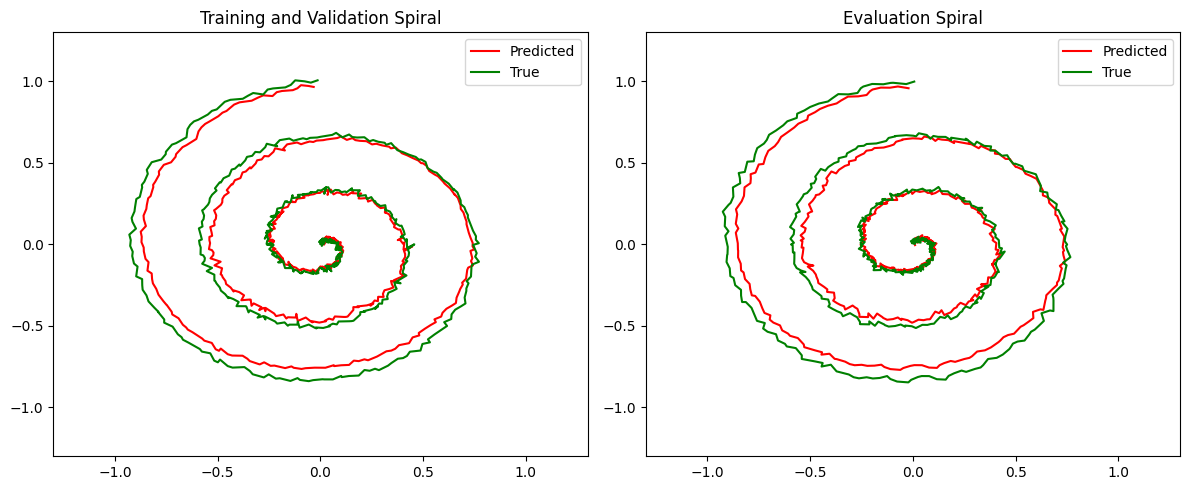

Epoch [500/1000], Total train loss: 0.122909, val loss: 0.005169, eval loss: 0.005113


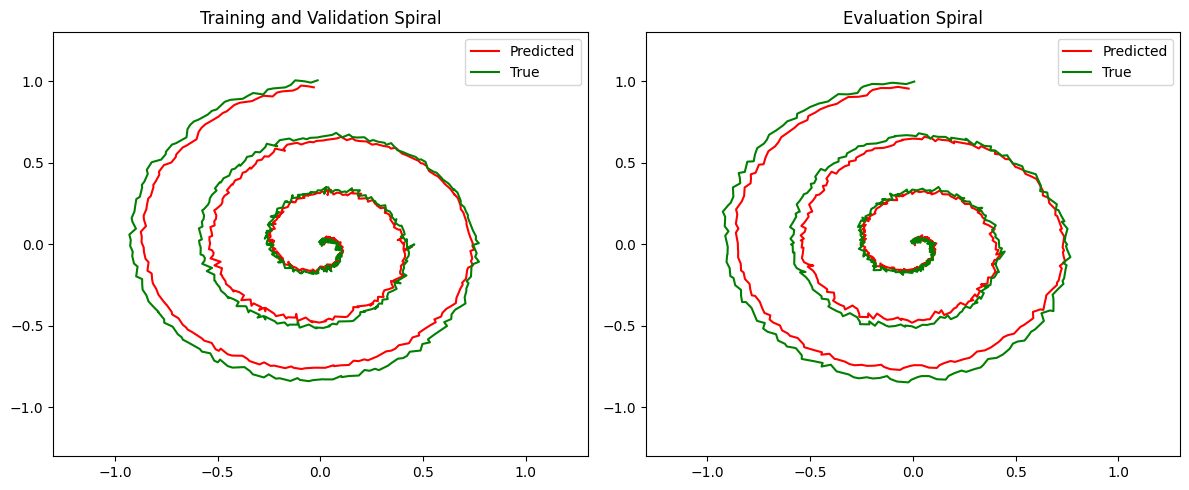

Epoch [600/1000], Total train loss: 0.120540, val loss: 0.005157, eval loss: 0.005101


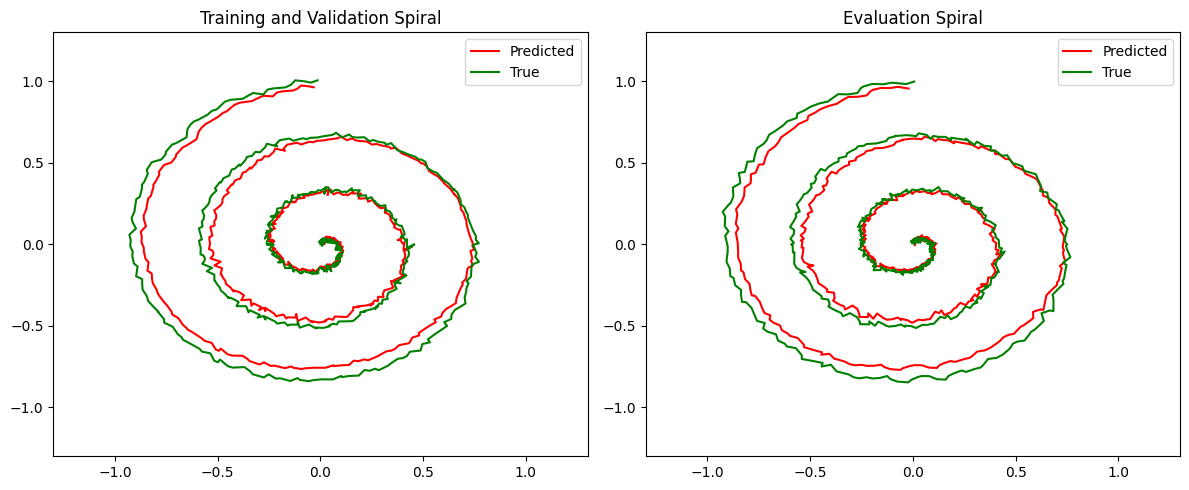

Epoch [700/1000], Total train loss: 0.117315, val loss: 0.005158, eval loss: 0.005102


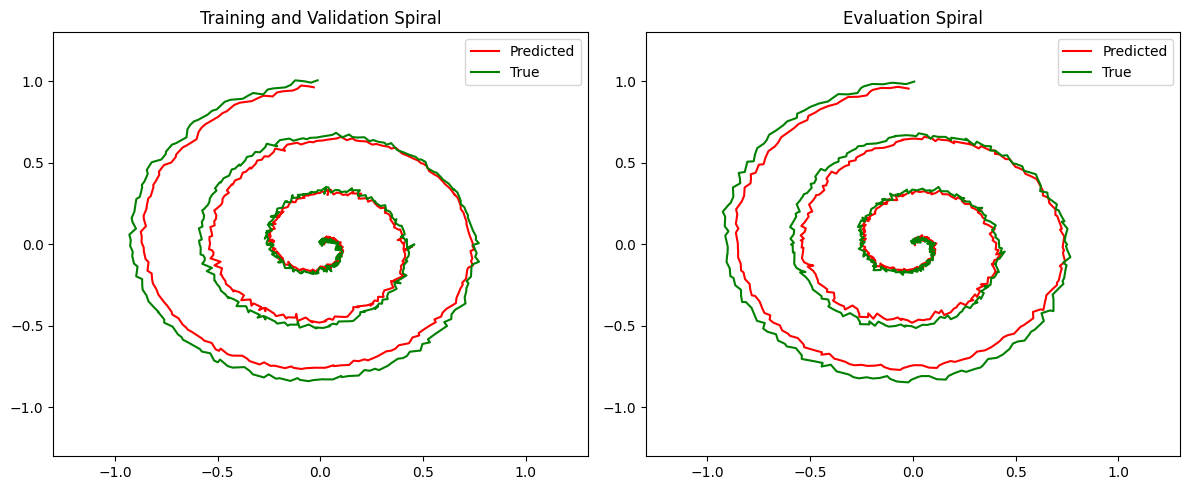

Epoch [800/1000], Total train loss: 0.117978, val loss: 0.005158, eval loss: 0.005102


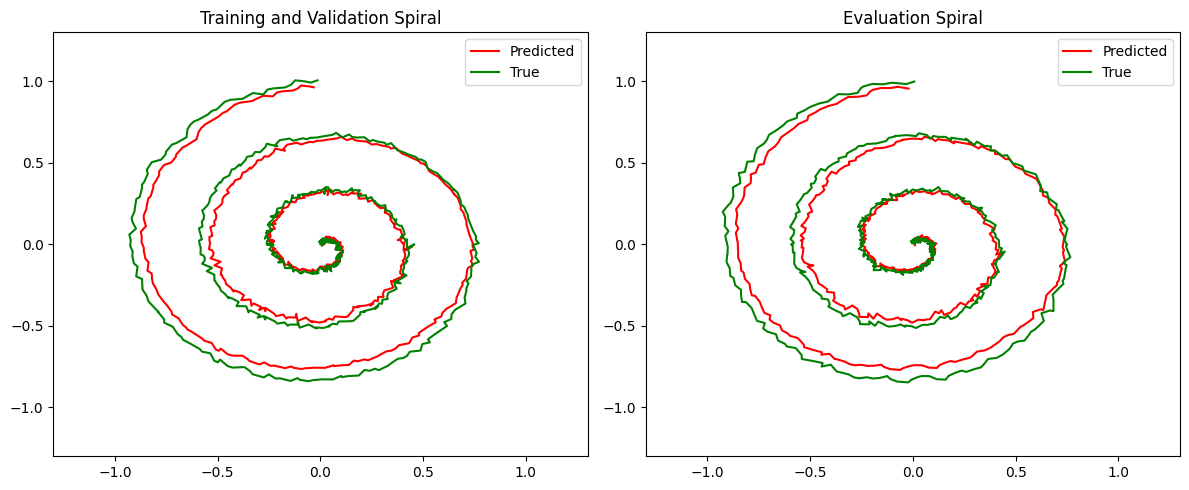

Epoch [900/1000], Total train loss: 0.122819, val loss: 0.005158, eval loss: 0.005102


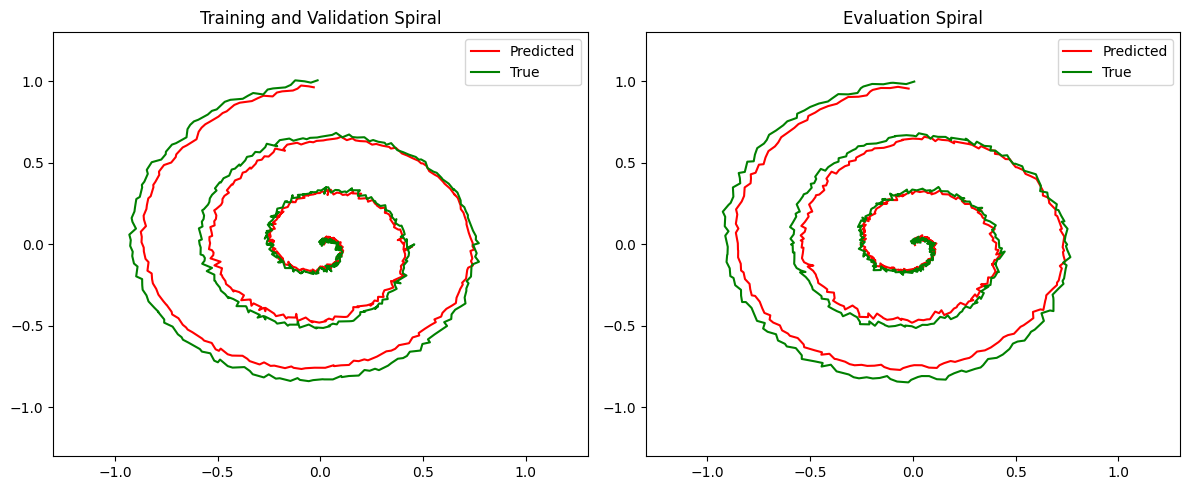

Epoch [1000/1000], Total train loss: 0.105846, val loss: 0.005158, eval loss: 0.005102


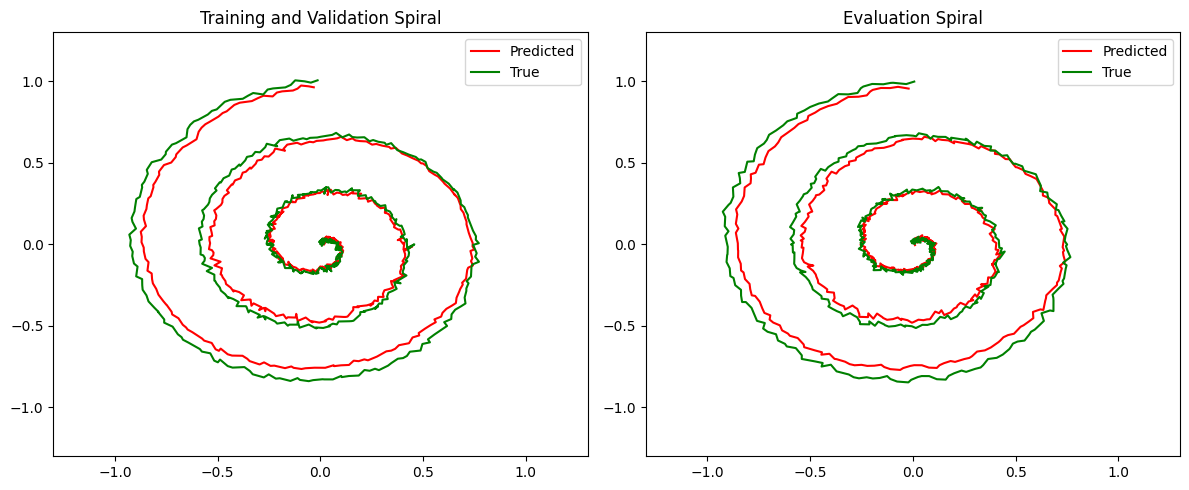

In [63]:
learning_rate = 0.001
num_epochs = 1000
seq_len = 3
batch_size = 32

# Use the same normalised data from before (sample_data)
# sample_data
all_inputs = sample_data[:-1, :]
all_targets = sample_data[1:, :]
eval_inputs = eval_data[:-1, :]
eval_targets = eval_data[1:, :]

# Denormalise targets for plotting
all_targets_denorm, _, _ = denormalise(all_targets, mean, std)
eval_targets_denorm, _, _ = denormalise(eval_targets, mean, std)

trajectory_count = max(1, len(all_inputs) - seq_len)
train_inputs = [torch.FloatTensor(all_inputs[i:i + seq_len]) for i in range(trajectory_count)]
train_targets = [torch.FloatTensor(all_targets[i:i + seq_len]) for i in range(trajectory_count)]

random_train_indices = np.arange(len(train_inputs))
rng = np.random.default_rng(seed=SEED)
rng.shuffle(random_train_indices)
train_split_index = int(len(random_train_indices) * 0.8)
random_train_indices = random_train_indices[:train_split_index]

train_input_batches = [train_inputs[i] for i in random_train_indices]
train_target_batches = [train_targets[i] for i in random_train_indices]

def create_batches(data_list, batch_size):
    return [data_list[i:i + batch_size] for i in range(0, len(data_list), batch_size)]

train_input_batches = create_batches([train_inputs[i] for i in random_train_indices], batch_size)
train_target_batches = create_batches([train_targets[i] for i in random_train_indices], batch_size)

lstm_model = LSTMModel()

criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

for epoch in range(num_epochs):
    lstm_model.train()
    total_loss = 0

    for x_batch, y_batch in zip(train_input_batches, train_target_batches):
        x = torch.stack(x_batch)
        y = torch.stack(y_batch)

        optimizer.zero_grad()
        outputs = lstm_model(x)
        loss = criterion(outputs, y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Evaluation and plotting every 100 epochs (as well as the first two epochs)
    if (epoch + 1) % 100 == 0 or epoch == 0 or epoch == 1:
        lstm_model.eval()
        with torch.no_grad():
            train_and_validation_set_pred = lstm_model(torch.FloatTensor(all_inputs).unsqueeze(0))
            eval_set_pred = lstm_model(torch.FloatTensor(eval_inputs).unsqueeze(0))
            val_loss = criterion(train_and_validation_set_pred, torch.FloatTensor(all_targets).unsqueeze(0))
            eval_loss = criterion(eval_set_pred, torch.FloatTensor(eval_targets).unsqueeze(0))

        print(f'Epoch [{epoch+1}/{num_epochs}], Total train loss: {total_loss:.6f}, val loss: {val_loss:.6f}, eval loss: {eval_loss:.6f}')
            
        # Denormalise and plot
        train_pred_denorm, _, _ = denormalise(train_and_validation_set_pred.squeeze(0).numpy(), mean, std)
        eval_pred_denorm, _, _ = denormalise(eval_set_pred.squeeze(0).numpy(), mean, std)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        axes[0].plot(train_pred_denorm[:, 0], train_pred_denorm[:, 1], 'r-', label='Predicted')
        axes[0].plot(all_targets_denorm[:, 0], all_targets_denorm[:, 1], 'g-', label='True')
        axes[0].set_title("Training and Validation Spiral")
        axes[0].set_xlim(-1.3, 1.3)
        axes[0].set_ylim(-1.3, 1.3)
        axes[0].legend()

        axes[1].plot(eval_pred_denorm[:, 0], eval_pred_denorm[:, 1], 'r-', label='Predicted')
        axes[1].plot(eval_targets_denorm[:, 0], eval_targets_denorm[:, 1], 'g-', label='True')
        axes[1].set_title("Evaluation Spiral")
        axes[1].set_xlim(-1.3, 1.3)
        axes[1].set_ylim(-1.3, 1.3)
        axes[1].legend()

        plt.tight_layout()
        plt.show()

In [33]:
torch.save(lstm_model, "lstm_model.pt")

In [95]:
lstm_model = torch.load("lstm_model.pt", weights_only=False)

# Transformer Model

In [96]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim=2, model_dim=128, num_heads=4, num_layers=2, output_dim=2, dropout=0.1, max_len=500):
        super(TransformerModel, self).__init__()

        self.input_proj = nn.Linear(input_dim, model_dim)

        self.pos_embed = nn.Parameter(torch.zeros(1, max_len, model_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

        # Multihead attention and feedforward layers   
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=256,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.norm = nn.LayerNorm(model_dim)

        self.output_head = nn.Sequential(
            nn.Linear(model_dim, model_dim // 2),
            nn.ReLU(),
            nn.Linear(model_dim // 2, output_dim)
        )

    def forward(self, x):
        x = self.input_proj(x)  # [batch, seq_len, model_dim]
        x = x + self.pos_embed[:, :x.size(1)]
        
        # Causal mask for autoregressive behaviour
        seq_len = x.size(1)
        mask = torch.triu(torch.full((seq_len, seq_len), float('-inf')), diagonal=1).to(x.device)

        x = self.encoder(x, mask=mask)
        x = self.norm(x)
        return self.output_head(x)


Epoch [1/2000], Total train loss: 3.619919, val loss: 0.342889, eval loss: 0.342358


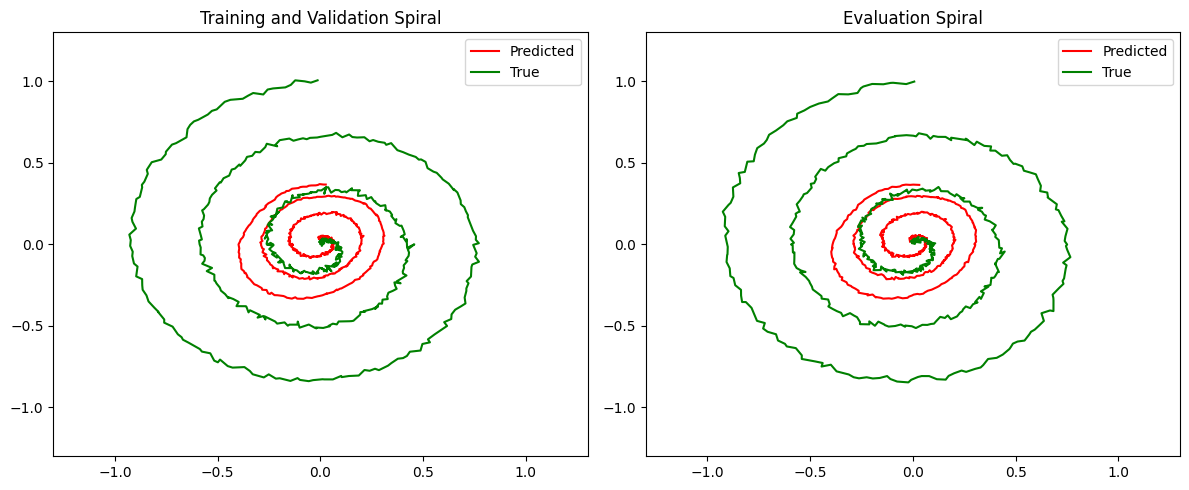

Epoch [2/2000], Total train loss: 0.479808, val loss: 0.365467, eval loss: 0.364942


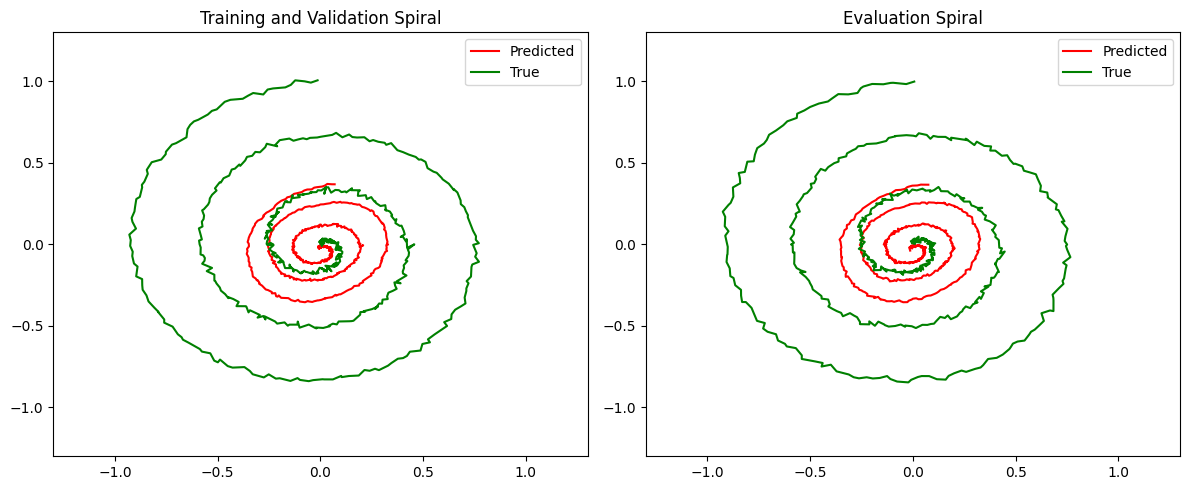

Epoch [100/2000], Total train loss: 0.020830, val loss: 0.223893, eval loss: 0.223464


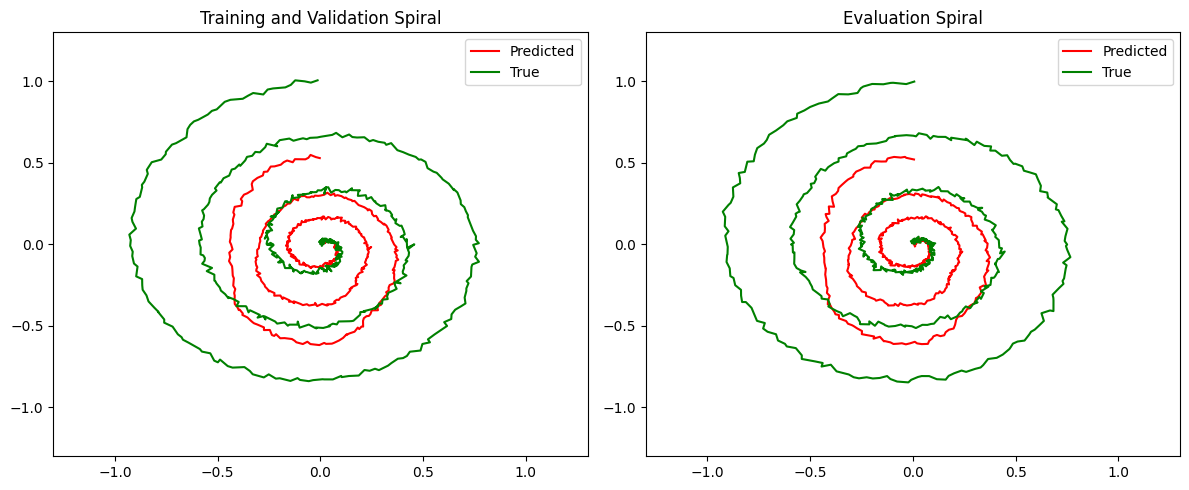

Epoch [200/2000], Total train loss: 0.020775, val loss: 0.180521, eval loss: 0.180461


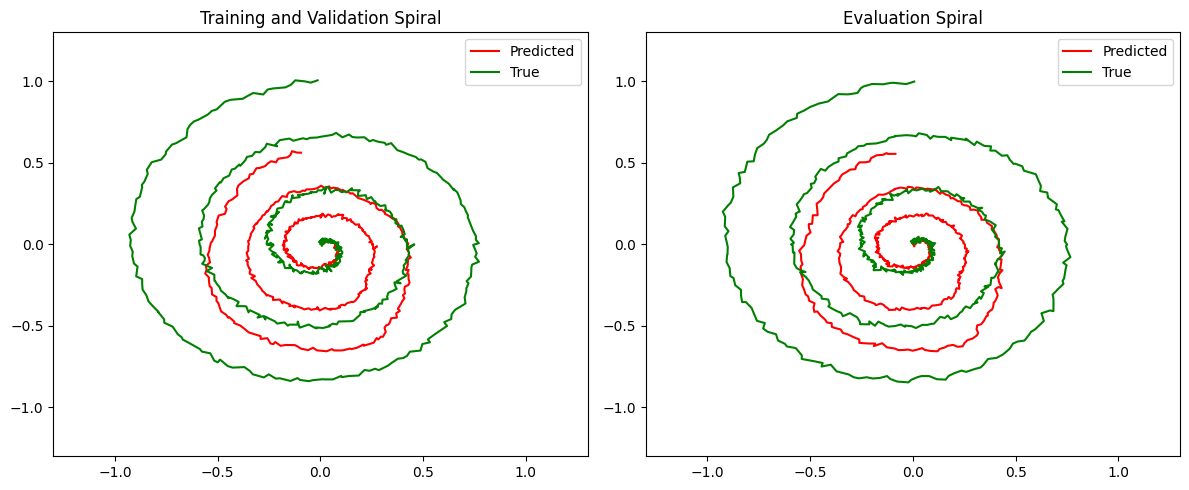

Epoch [300/2000], Total train loss: 0.020807, val loss: 0.011452, eval loss: 0.011276


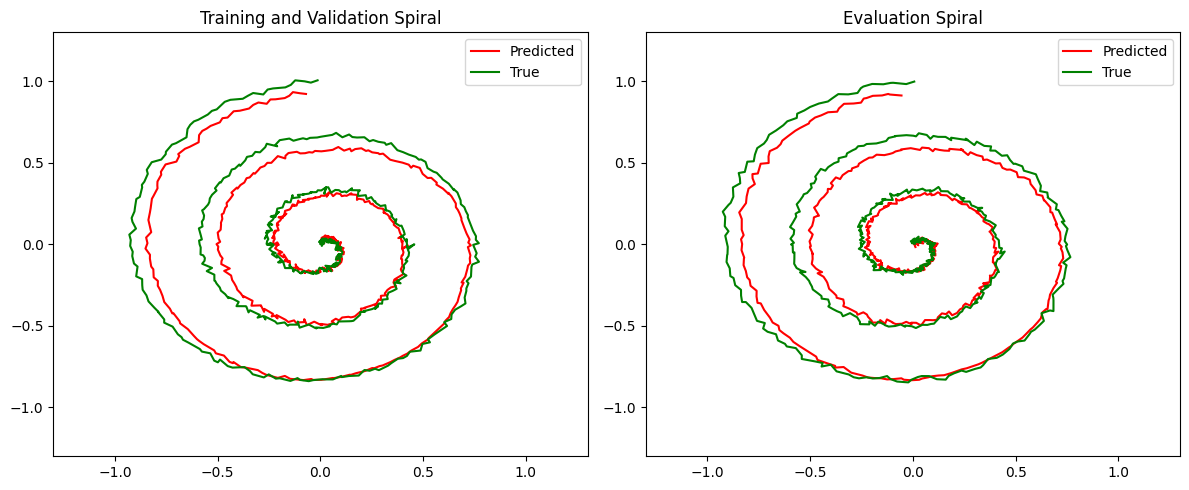

Epoch [400/2000], Total train loss: 0.014551, val loss: 0.001953, eval loss: 0.001865


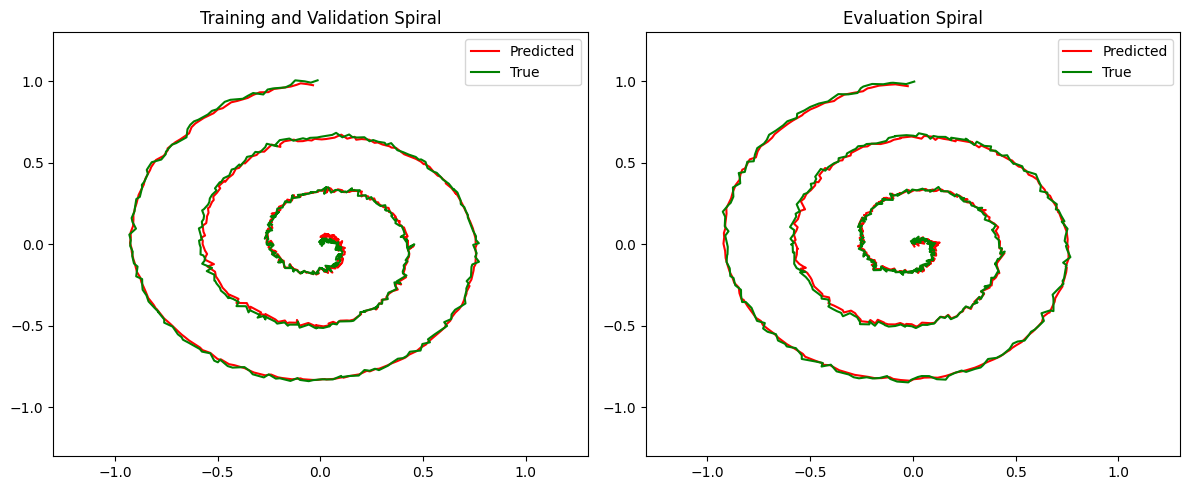

Epoch [500/2000], Total train loss: 0.011817, val loss: 0.001781, eval loss: 0.001657


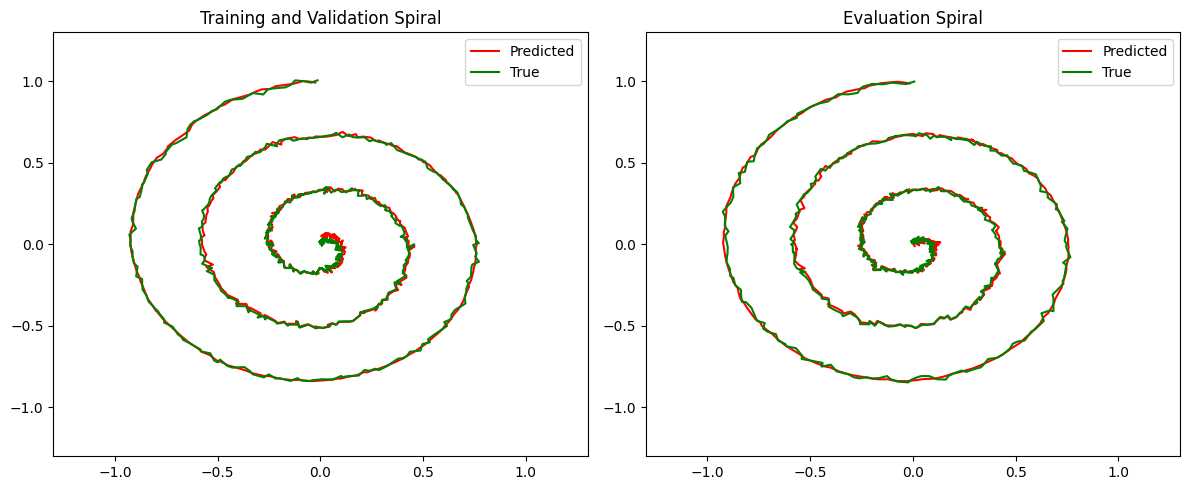

Epoch [600/2000], Total train loss: 0.027975, val loss: 0.002722, eval loss: 0.002785


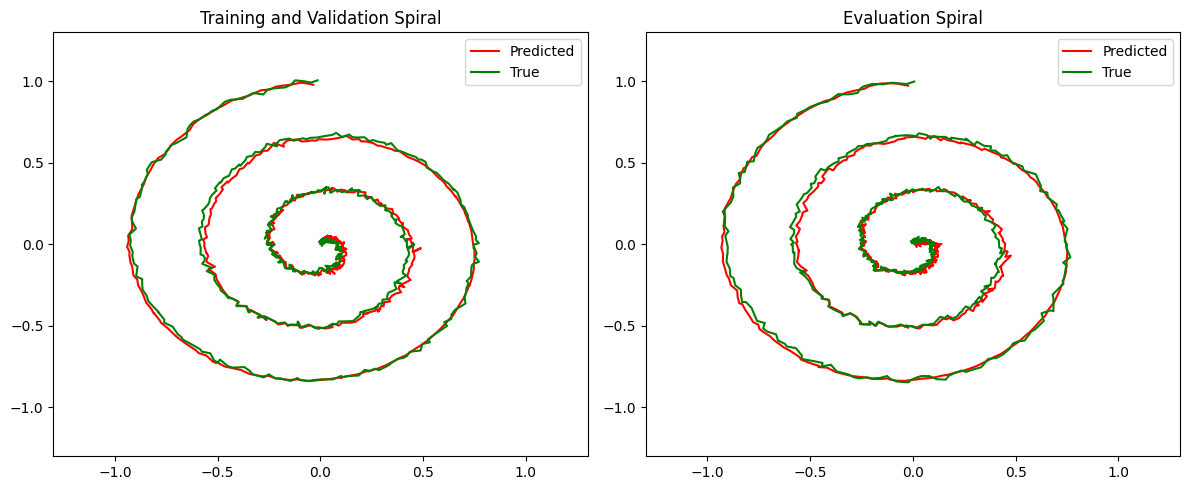

Epoch [700/2000], Total train loss: 0.013193, val loss: 0.002186, eval loss: 0.002235
Early stopping triggered at epoch 700. Best val loss: 0.001781


In [68]:
learning_rate = 0.001
num_epochs = 2000
seq_len = 3
batch_size = 32

# Use the same normalised data from before (sample_data)
# sample_data
all_inputs = sample_data[:-1, :]
all_targets = sample_data[1:, :]
eval_inputs = eval_data[:-1, :]
eval_targets = eval_data[1:, :]

# Denormalise targets for plotting
all_targets_denorm, _, _ = denormalise(all_targets, mean, std)
eval_targets_denorm, _, _ = denormalise(eval_targets, mean, std)

trajectory_count = max(1, len(all_inputs) - seq_len)
train_inputs = [torch.FloatTensor(all_inputs[i:i + seq_len]) for i in range(trajectory_count)]
train_targets = [torch.FloatTensor(all_targets[i:i + seq_len]) for i in range(trajectory_count)]

random_train_indices = np.arange(len(train_inputs))
rng = np.random.default_rng(seed=SEED)
rng.shuffle(random_train_indices)
train_split_index = int(len(random_train_indices) * 0.8)
random_train_indices = random_train_indices[:train_split_index]

train_input_batches = [train_inputs[i] for i in random_train_indices]
train_target_batches = [train_targets[i] for i in random_train_indices]

def create_batches(data_list, batch_size):
    return [data_list[i:i + batch_size] for i in range(0, len(data_list), batch_size)]

train_input_batches = create_batches([train_inputs[i] for i in random_train_indices], batch_size)
train_target_batches = create_batches([train_targets[i] for i in random_train_indices], batch_size)

transformer_model = TransformerModel()

criterion = nn.MSELoss()
# optimizer = optim.Adam(transformer_model.parameters(), lr=learning_rate)
optimizer = torch.optim.AdamW(transformer_model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

best_val_loss = float('inf')
best_model_state = None
patience = 200
epochs_without_improvement = 0

for epoch in range(num_epochs):
    transformer_model.train()
    total_loss = 0

    for x_batch, y_batch in zip(train_input_batches, train_target_batches):
        x = torch.stack(x_batch)
        y = torch.stack(y_batch)

        optimizer.zero_grad()
        outputs = transformer_model(x)
        loss = criterion(outputs, y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Evaluation and plotting every 100 epochs (as well as the first two epochs)
    if (epoch + 1) % 100 == 0 or epoch == 0 or epoch == 1:
        transformer_model.eval()
        with torch.no_grad():
            train_and_validation_set_pred = transformer_model(torch.FloatTensor(all_inputs).unsqueeze(0))
            eval_set_pred = transformer_model(torch.FloatTensor(eval_inputs).unsqueeze(0))
            val_loss = criterion(train_and_validation_set_pred, torch.FloatTensor(all_targets).unsqueeze(0))
            eval_loss = criterion(eval_set_pred, torch.FloatTensor(eval_targets).unsqueeze(0))

        print(f'Epoch [{epoch+1}/{num_epochs}], Total train loss: {total_loss:.6f}, val loss: {val_loss:.6f}, eval loss: {eval_loss:.6f}')

        if val_loss.item() < best_val_loss - 1e-6:
            best_val_loss = val_loss.item()
            best_model_state = transformer_model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 100
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best val loss: {best_val_loss:.6f}")
            transformer_model.load_state_dict(best_model_state)
            break
  
        # Denormalise and plot
        train_pred_denorm, _, _ = denormalise(train_and_validation_set_pred.squeeze(0).numpy(), mean, std)
        eval_pred_denorm, _, _ = denormalise(eval_set_pred.squeeze(0).numpy(), mean, std)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        axes[0].plot(train_pred_denorm[:, 0], train_pred_denorm[:, 1], 'r-', label='Predicted')
        axes[0].plot(all_targets_denorm[:, 0], all_targets_denorm[:, 1], 'g-', label='True')
        axes[0].set_title("Training and Validation Spiral")
        axes[0].set_xlim(-1.3, 1.3)
        axes[0].set_ylim(-1.3, 1.3)
        axes[0].legend()

        axes[1].plot(eval_pred_denorm[:, 0], eval_pred_denorm[:, 1], 'r-', label='Predicted')
        axes[1].plot(eval_targets_denorm[:, 0], eval_targets_denorm[:, 1], 'g-', label='True')
        axes[1].set_title("Evaluation Spiral")
        axes[1].set_xlim(-1.3, 1.3)
        axes[1].set_ylim(-1.3, 1.3)
        axes[1].legend()

        plt.tight_layout()
        plt.show()
    

In [69]:
torch.save(transformer_model, "transformer_model.pt")

In [97]:
transformer_model = torch.load("transformer_model.pt", weights_only=False)

On the final epoch:
- LNN has a training loss of 0.0006 and validation loss of ______
- TCN has a training loss of 0.0002 and validation loss of ______
- LSTM has a training loss of 0.0004 and validation loss of ______
- Transformer has a training loss of _____ and validation loss of _____

These are comparable neural networks (similar MSE loss values)

# Model Inference

LTC Inference Metrics: MSE = 0.001834, RMSE = 0.042826, MAE  = 0.034104


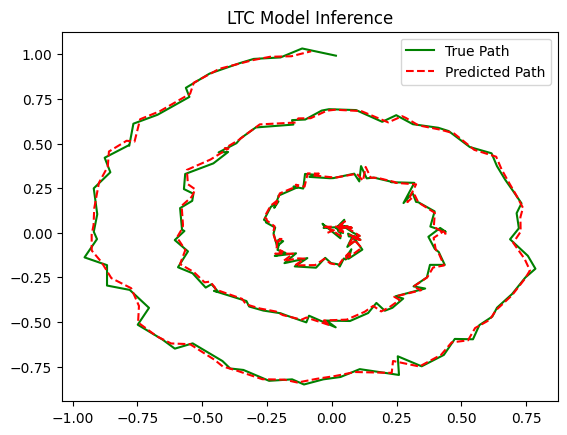

TCN Inference Metrics: MSE = 0.001909, RMSE = 0.043692, MAE  = 0.035089


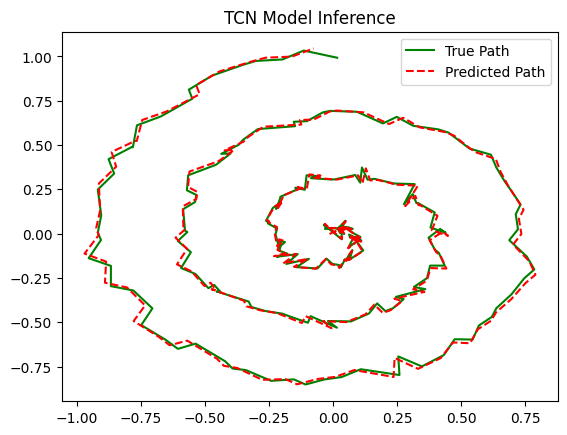

LSTM Inference Metrics: MSE = 0.001866, RMSE = 0.043194, MAE  = 0.034878


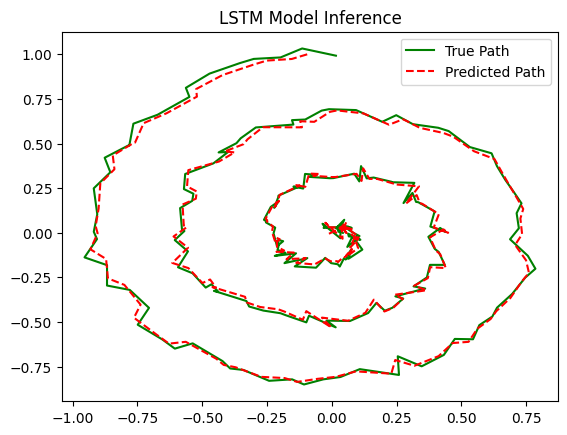

Transformer Inference Metrics: MSE = 0.001978, RMSE = 0.044473, MAE  = 0.035781


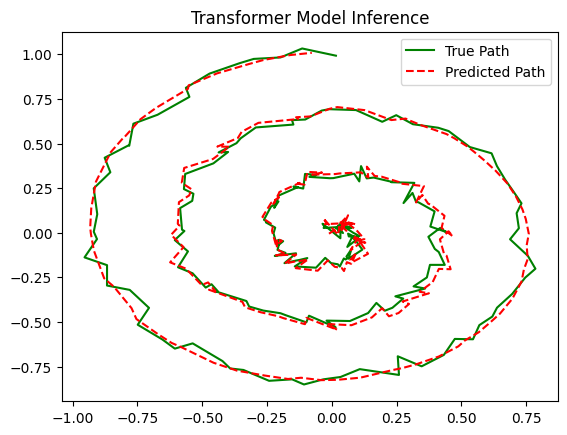

In [98]:
def infer_spiral(model, input_seq, target_seq=None):
    model_names = {
            LTCRNN: "LTC",
            TCN: "TCN",
            LSTMModel: "LSTM",
            TransformerModel: "Transformer"
        }

    model.eval()

    # Normalise input data using the same mean and std dev as before
    normalised_input_seq, _, _ = normalise(input_seq, mean, std)

    with torch.no_grad():
        x = torch.FloatTensor(normalised_input_seq).unsqueeze(0)
        predictions = model(x).squeeze(0).numpy()

    # Denormalise predictions, to calculate metrics and plot in denormalised (original) space
    predictions, _, _ = denormalise(predictions, mean, std)

    if target_seq is not None:
        if isinstance(target_seq, torch.Tensor):
            target_seq = target_seq.numpy()
        
        mse = mean_squared_error(target_seq, predictions)
        mae = mean_absolute_error(target_seq, predictions)
        rmse = np.sqrt(mse)

        print(f"{model_names[type(model)]} Inference Metrics: MSE = {mse:.6f}, RMSE = {rmse:.6f}, MAE  = {mae:.6f}")

        plt.plot(target_seq[:, 0], target_seq[:, 1], 'g-', label='True Path') 
    plt.plot(predictions[:, 0], predictions[:, 1], 'r--', label='Predicted Path')
    plt.legend()
    title = f"{model_names[type(model)]} Model Inference"
    plt.title(title)
    plt.show()

    return predictions

test_data = generate_spiral_data(num_points=200, num_turns=3, seed=SEED+2)


test_inputs = test_data[:-1, :] 
test_targets = test_data[1:, :]


lnn_preds = infer_spiral(lnn_model, test_inputs, test_targets)
tcn_preds = infer_spiral(tcn_model, test_inputs, test_targets)
lstm_preds = infer_spiral(lstm_model, test_inputs, test_targets)
transformer_preds = infer_spiral(transformer_model, test_inputs, test_targets)

In [99]:
# Helper function to display datapoints in target, predictions and adversarial predictions
# For debugging attacks
def display_datapoints(test_input, test_target, adv_output, skip=100):
    assert (test_input.shape[0] == test_target.shape[0] == adv_output.shape[0]), "Input, target and adversarial output must have the same number of samples"

    for i in range(0, test_input.shape[0], skip):
        print("-" * 60)
        print(f"{f'Datapoint {i}':^60}")
        print(f"{'Target Value:':>30} {str(test_target[i]):>30}")
        print(f"{'Original Prediction:':>30} {str(test_input[i]):>30}")
        print(f"{'Adversarial Prediction:':>30} {str(adv_output[i]):>30}")
    print("-" * 20)

# Robustness Metrics Function

In [100]:
# Helper function to calculate and display robustness metrics, given an adversarial output and original output
# Note - value inputs should be NORMALISED when passed in
def get_robustness_metrics(model: LTCRNN | TCN | LSTMModel | TransformerModel,
                           output: torch.FloatTensor,
                           adv_output_tensor: torch.FloatTensor,
                           input: torch.FloatTensor,
                           adv_input_tensor: torch.FloatTensor,
                           target_tensor: torch.FloatTensor):
    orig_loss = F.mse_loss(output, target_tensor).item()
    adv_loss = F.mse_loss(adv_output_tensor, target_tensor).item()
    robustness_ratio = (adv_loss - orig_loss) / (orig_loss + 1e-8)
    deviation = torch.norm(output - adv_output_tensor).item()

    input_delta = torch.norm(input - adv_input_tensor).item()
    output_delta = torch.norm(output - adv_output_tensor).item()
    lipschitz_estimate = output_delta / (input_delta + 1e-8)


    model_names = {
            LTCRNN: "LTC",
            TCN: "TCN",
            LSTMModel: "LSTM",
            TransformerModel: "Transformer"
        }
    model_type = model_names[type(model)]

    print(f"[{model_type}] | Original Loss: {orig_loss:.6f} | Adversarial Loss: {adv_loss:.6f} | Degradation: {robustness_ratio:.4%} | Deviation: {deviation:.6f} | Lipschitz Est.: {lipschitz_estimate:.6f}")

# FGSM Attack

In [107]:
def run_manual_fgsm_attack(model, input_seq, target_seq, epsilon=0.05):
    model.eval()

    # Normalise input data and target seq using the same mean and std dev that training data had
    normalised_input_seq, _, _ = normalise(input_seq, mean, std)
    normalised_target_seq, _, _ = normalise(target_seq, mean, std)

    normalised_input_tensor = torch.FloatTensor(normalised_input_seq).unsqueeze(0).requires_grad_(True)
    normalised_target_tensor = torch.FloatTensor(normalised_target_seq).unsqueeze(0)

    normalised_original_output = model(normalised_input_tensor)
    loss = F.mse_loss(normalised_original_output, normalised_target_tensor)
    model.zero_grad()
    loss.backward()
    normalised_original_output = normalised_original_output.squeeze(0).detach()

    # Generate input perturbation using input_tensor grad sign
    perturbation = epsilon * normalised_input_tensor.grad.data.sign()
    adv_input_tensor = normalised_input_tensor + perturbation
    adv_input_tensor = adv_input_tensor.detach()

    adv_output_tensor = model(adv_input_tensor).squeeze(0).detach()

    get_robustness_metrics(model, normalised_original_output, adv_output_tensor, normalised_input_tensor, adv_input_tensor, normalised_target_tensor.squeeze(0))

    # Denormalise for plotting
    adv_output, _, _ = denormalise(adv_output_tensor, mean, std)
    original_output, _, _ = denormalise(normalised_original_output, mean, std)

    plt.plot(target_seq[:, 0], target_seq[:, 1], 'g-', label='True Path')
    plt.plot(original_output[:, 0], original_output[:, 1], 'r--', label='Original Prediction')
    plt.plot(adv_output[:, 0], adv_output[:, 1], 'b--', label='Adversarial Prediction')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    model_names = {
            LTCRNN: "LTC",
            TCN: "TCN",
            LSTMModel: "LSTM",
            TransformerModel: "Transformer"
        }
    title = f"Manual FGSM Attack (epsilon={epsilon}) on {model_names[type(model)]} Model"
    plt.title(title)
    plt.show()

    return

[LTC] | Original Loss: 0.002795 | Adversarial Loss: 0.008656 | Degradation: 209.6842% | Deviation: 1.293169 | Lipschitz Est.: 0.915554


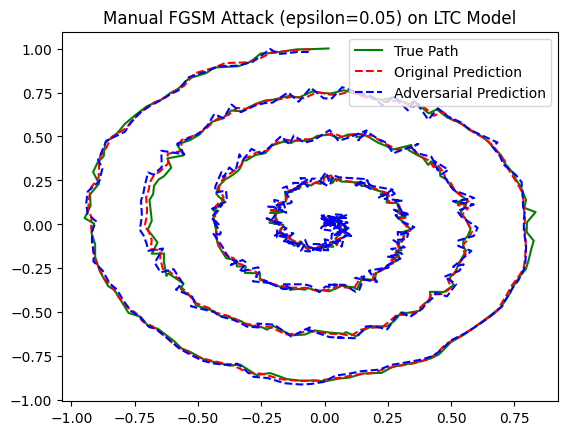

[TCN] | Original Loss: 0.002782 | Adversarial Loss: 0.009531 | Degradation: 242.5555% | Deviation: 1.419442 | Lipschitz Est.: 1.004954


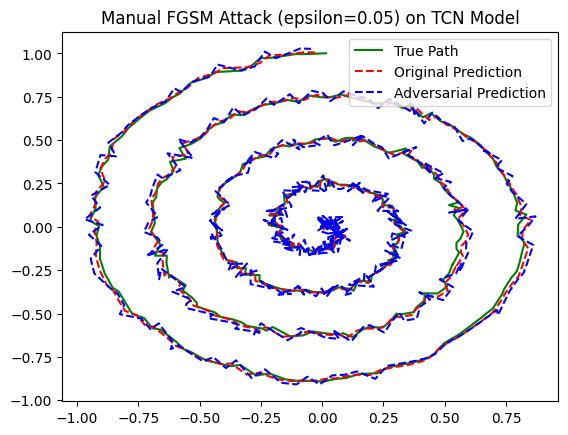

[LSTM] | Original Loss: 0.004416 | Adversarial Loss: 0.011903 | Degradation: 169.5259% | Deviation: 1.367006 | Lipschitz Est.: 0.967830


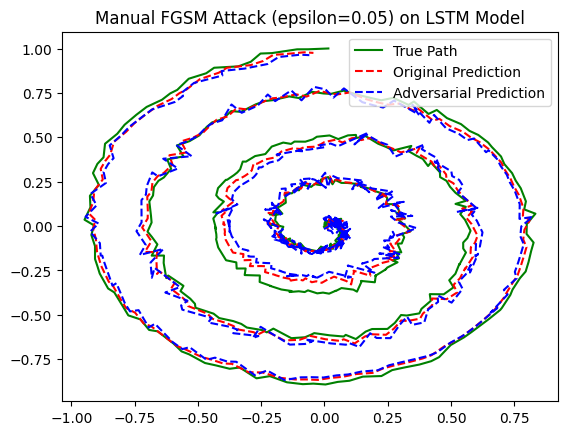

[Transformer] | Original Loss: 0.007677 | Adversarial Loss: 0.017109 | Degradation: 122.8652% | Deviation: 1.474218 | Lipschitz Est.: 1.043735


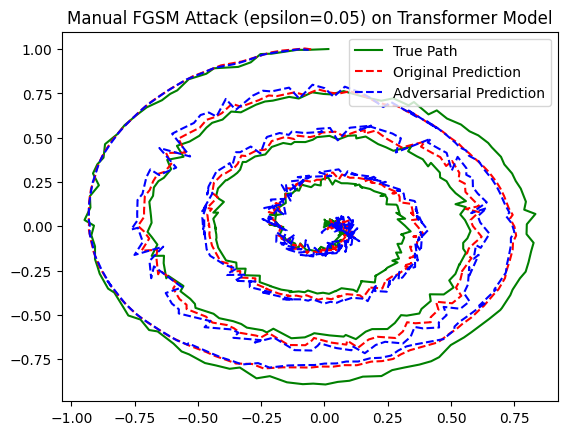

In [108]:
test_data = generate_spiral_data(400, 4, seed=SEED)
test_input = test_data[:-1]
test_target = test_data[1:]

# Run attack on LNN
run_manual_fgsm_attack(lnn_model, test_input, test_target, epsilon=0.05)

# Run attack on TCN
run_manual_fgsm_attack(tcn_model, test_input, test_target, epsilon=0.05)

# Run attack on LSTM
run_manual_fgsm_attack(lstm_model, test_input, test_target, epsilon=0.05)

# Run attack on Transformer
run_manual_fgsm_attack(transformer_model, test_input, test_target, epsilon=0.05)

# PGD Attack

In [109]:
def run_pgd_attack(model, input_seq, target_seq, epsilon=0.05, alpha=0.01, num_iter=10):
    model.eval()

    # Normalise input data and target seq using the same mean and std dev as before
    normalised_input_seq, _, _ = normalise(input_seq, mean, std)
    normalised_target_seq, _, _ = normalise(target_seq, mean, std)

    normalised_input_tensor = torch.FloatTensor(normalised_input_seq).unsqueeze(0).requires_grad_(True)
    normalised_target_tensor = torch.FloatTensor(normalised_target_seq).unsqueeze(0)

    adv_input_tensor = normalised_input_tensor.clone().detach().requires_grad_(True)

    for _ in range(num_iter):
        normalised_output_tensor = model(adv_input_tensor)
        loss = F.mse_loss(normalised_output_tensor, normalised_target_tensor)

        model.zero_grad()
        loss.backward()

        # Gradient ascent so move in the direction that increases loss
        with torch.no_grad():
            adv_input_tensor += alpha * adv_input_tensor.grad.sign()

            perturbation = torch.clamp(adv_input_tensor - normalised_input_tensor, min=-epsilon, max=epsilon)
            adv_input_tensor = torch.clamp(normalised_input_tensor + perturbation, min=normalised_input_tensor.min(), max=normalised_input_tensor.max())
            adv_input_tensor.requires_grad_(True)

    adv_output_tensor = model(adv_input_tensor).squeeze(0).detach()
    original_output_tensor = model(normalised_input_tensor).squeeze(0).detach()

    get_robustness_metrics(model, original_output_tensor, adv_output_tensor, normalised_input_tensor, adv_input_tensor, normalised_target_tensor.squeeze(0))

    # Denormalise for plotting
    adv_output, _, _ = denormalise(adv_output_tensor, mean, std)
    original_output, _, _ = denormalise(original_output_tensor, mean, std)

    plt.plot(target_seq[:, 0], target_seq[:, 1], 'g-', label='True Path')
    plt.plot(original_output[:, 0], original_output[:, 1], 'r--', label='Original Prediction')
    plt.plot(adv_output[:, 0], adv_output[:, 1], 'b--', label='PGD Adversarial Prediction')
    plt.legend()

    model_names = {
            LTCRNN: "LTC",
            TCN: "TCN",
            LSTMModel: "LSTM",
            TransformerModel: "Transformer"
        }
    title = f"PGD Attack (epsilon={epsilon}, alpha={alpha}, iter={num_iter}) on {model_names[type(model)]} Model"
    plt.title(title)
    plt.show()

    return

[LTC] | Original Loss: 0.002795 | Adversarial Loss: 0.008655 | Degradation: 209.6700% | Deviation: 1.293832 | Lipschitz Est.: 0.919326


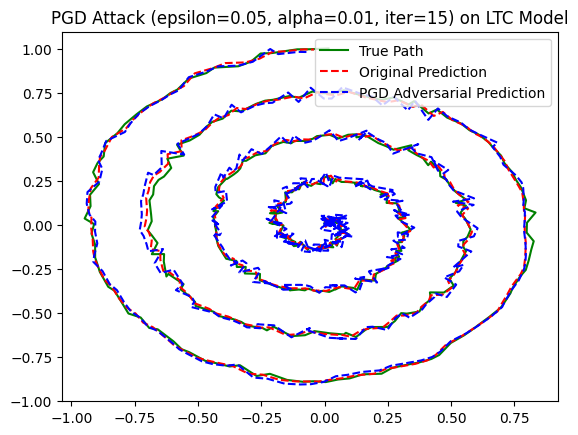

[TCN] | Original Loss: 0.002782 | Adversarial Loss: 0.009507 | Degradation: 241.7085% | Deviation: 1.416078 | Lipschitz Est.: 1.005099


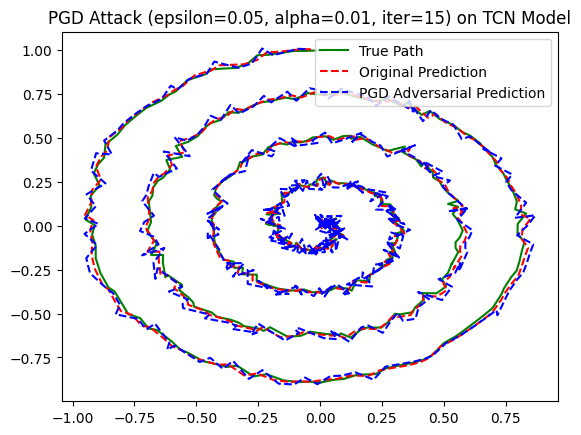

[LSTM] | Original Loss: 0.004416 | Adversarial Loss: 0.011904 | Degradation: 169.5408% | Deviation: 1.367387 | Lipschitz Est.: 0.968100


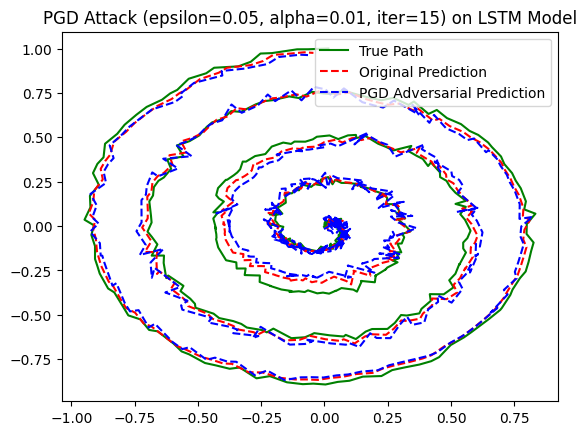

[Transformer] | Original Loss: 0.007677 | Adversarial Loss: 0.017500 | Degradation: 127.9633% | Deviation: 1.527660 | Lipschitz Est.: 1.090577


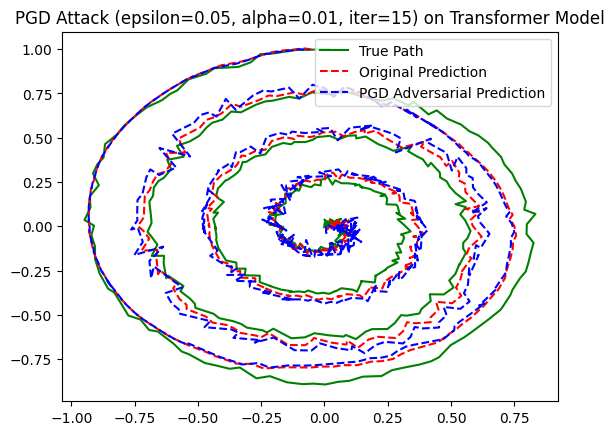

In [110]:
test_data = generate_spiral_data(400, 4, seed=SEED)
test_input = test_data[:-1]
test_target = test_data[1:]

# Run attack on LNN
run_pgd_attack(lnn_model, test_input, test_target, epsilon=0.05, alpha=0.01, num_iter=15)

# Run attack on TCN
run_pgd_attack(tcn_model, test_input, test_target, epsilon=0.05, alpha=0.01, num_iter=15)

# Run attack on LSTM
run_pgd_attack(lstm_model, test_input, test_target, epsilon=0.05, alpha=0.01, num_iter=15)

# Run attack on Transformer
run_pgd_attack(transformer_model, test_input, test_target, epsilon=0.05, alpha=0.01, num_iter=15)

# DeepFool Attack

In [111]:
def run_deepfool_like_attack(model, input_seq, target_seq, max_iter=20, step_size=0.005):
    model.eval()

    # Normalise input data and target seq using the same mean and std dev as before
    normalised_input_seq, _, _ = normalise(input_seq, mean, std)
    normalised_target_seq, _, _ = normalise(target_seq, mean, std)

    normalised_input_tensor = torch.FloatTensor(normalised_input_seq).unsqueeze(0).requires_grad_(True)
    normalised_target_tensor = torch.FloatTensor(normalised_target_seq).unsqueeze(0)

    adv_input_tensor = normalised_input_tensor.clone().detach().requires_grad_(True)

    perturbation = torch.zeros_like(adv_input_tensor)

    for _ in range(max_iter):
        normalised_output_tensor = model(adv_input_tensor)
        loss = F.mse_loss(normalised_output_tensor, normalised_target_tensor, reduction='sum')

        model.zero_grad()
        loss.backward()

        grad = adv_input_tensor.grad.data
        grad_norm = torch.norm(grad)

        if grad_norm == 0:
            break

        # Compute minimal step in direction of gradient to move away from true output
        # r_i = (loss.item() / (grad_norm ** 2)) * grad
        r_i = step_size * grad / grad_norm
        perturbation += r_i
        # adv_input = input_tensor + (1 + overshoot) * perturbation
        adv_input_tensor = normalised_input_tensor + perturbation
        adv_input_tensor = adv_input_tensor.clone().detach().requires_grad_(True)

    adv_output_tensor = model(adv_input_tensor).squeeze(0).detach()
    original_output_tensor = model(normalised_input_tensor).squeeze(0).detach()

    get_robustness_metrics(model, original_output_tensor, adv_output_tensor, normalised_input_tensor, adv_input_tensor, normalised_target_tensor.squeeze(0))

    # Denormalise for plotting
    adv_output, _, _ = denormalise(adv_output_tensor, mean, std)
    original_output, _, _ = denormalise(original_output_tensor, mean, std)


    plt.plot(target_seq[:, 0], target_seq[:, 1], 'g-', label='True Path')
    plt.plot(original_output[:, 0], original_output[:, 1], 'r--', label='Original Prediction')
    plt.plot(adv_output[:, 0], adv_output[:, 1], 'b--', label='DeepFool-like Adversarial')
    plt.legend()

    model_names = {
            LTCRNN: "LTC",
            TCN: "TCN",
            LSTMModel: "LSTM",
            TransformerModel: "Transformer"
        }
    title = f"DeepFool-Like Attack (iter={max_iter}, step_size={step_size}) on {model_names[type(model)]} Model"
    plt.title(title)
    plt.show()

    return

[LTC] | Original Loss: 0.002795 | Adversarial Loss: 0.003145 | Degradation: 12.5395% | Deviation: 0.096296 | Lipschitz Est.: 0.962984


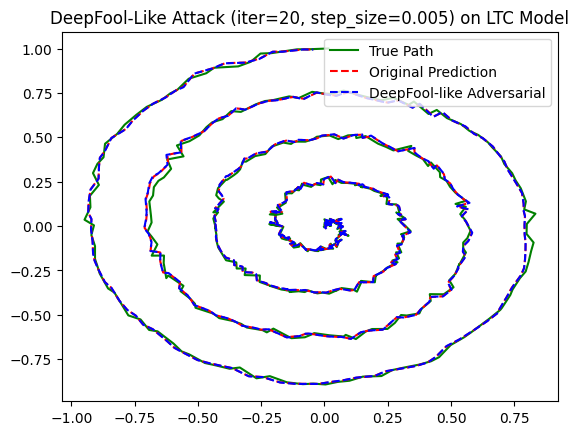

[TCN] | Original Loss: 0.002782 | Adversarial Loss: 0.003171 | Degradation: 13.9643% | Deviation: 0.101111 | Lipschitz Est.: 1.011127


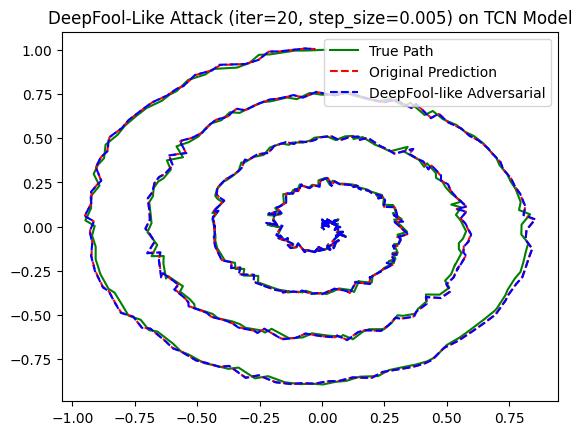

[LSTM] | Original Loss: 0.004416 | Adversarial Loss: 0.004914 | Degradation: 11.2735% | Deviation: 0.111709 | Lipschitz Est.: 1.117503


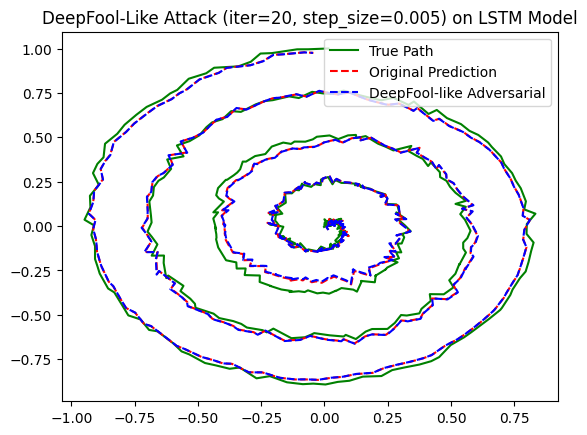

[Transformer] | Original Loss: 0.007677 | Adversarial Loss: 0.008355 | Degradation: 8.8294% | Deviation: 0.148173 | Lipschitz Est.: 1.497606


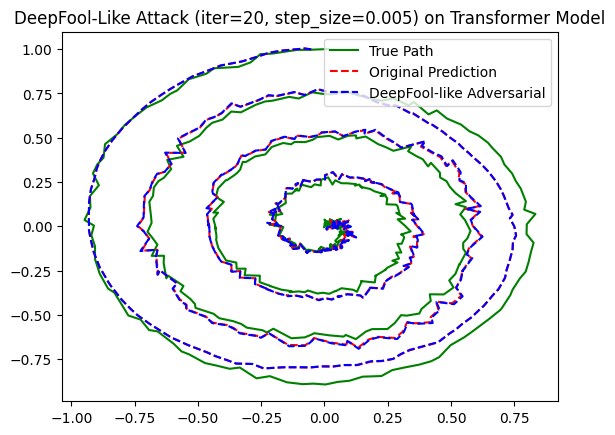

In [112]:
test_data = generate_spiral_data(400, 4, seed=SEED)
test_input = test_data[:-1]
test_target = test_data[1:]

# Run attack on LNN
run_deepfool_like_attack(lnn_model, test_input, test_target, step_size=0.005)

# Run attack on TCN
run_deepfool_like_attack(tcn_model, test_input, test_target, step_size=0.005)

# Run attack on LSTM
run_deepfool_like_attack(lstm_model, test_input, test_target, step_size=0.005)

# Run attack on Transformer
run_deepfool_like_attack(transformer_model, test_input, test_target, step_size=0.005)

# SPSA (Simultaneous Perturbation Stochastic Approximation)

In [113]:
def run_spsa_attack(model, input_seq, target_seq, epsilon=0.05, num_iter=20, delta=0.01, learning_rate=0.01):
    model.eval()

    # Normalise input data and target seq using the same mean and std dev as before
    normalised_input_seq, _, _ = normalise(input_seq, mean, std)
    normalised_target_seq, _, _ = normalise(target_seq, mean, std)

    normalised_input_tensor = torch.FloatTensor(normalised_input_seq).unsqueeze(0).requires_grad_(True)
    normalised_target_tensor = torch.FloatTensor(normalised_target_seq).unsqueeze(0)

    adv_input_tensor = normalised_input_tensor.clone().detach()
    
    for _ in range(num_iter):
        torch.random.seed()
        perturb = torch.sign(torch.randn_like(normalised_input_tensor))

        # Evaluate loss at positive and negative perturbations
        input_plus = adv_input_tensor + delta * perturb
        input_minus = adv_input_tensor - delta * perturb

        input_plus = input_plus.detach()
        input_minus = input_minus.detach()

        loss_plus = F.mse_loss(model(input_plus), normalised_target_tensor, reduction='sum')
        loss_minus = F.mse_loss(model(input_minus), normalised_target_tensor, reduction='sum')

        grad_estimate = (loss_plus - loss_minus) / (2 * delta) * perturb

        adv_input_tensor = adv_input_tensor + learning_rate * torch.sign(grad_estimate)

        # Clip adv input to stay within epsilon of original input
        perturbation = torch.clamp(adv_input_tensor - normalised_input_tensor, min=-epsilon, max=epsilon)
        adv_input_tensor = torch.clamp(normalised_input_tensor + perturbation, min=normalised_input_tensor.min(), max=normalised_input_tensor.max())

    adv_output_tensor = model(adv_input_tensor).squeeze(0).detach()
    original_output_tensor = model(normalised_input_tensor).squeeze(0).detach()

    get_robustness_metrics(model, original_output_tensor, adv_output_tensor, normalised_input_tensor, adv_input_tensor, normalised_target_tensor.squeeze(0))

    # Denormalise for plotting
    adv_output, _, _ = denormalise(adv_output_tensor, mean, std)
    original_output, _, _ = denormalise(original_output_tensor, mean, std)

    plt.plot(target_seq[:, 0], target_seq[:, 1], 'g-', label='True Path')
    plt.plot(original_output[:, 0], original_output[:, 1], 'r--', label='Original Prediction')
    plt.plot(adv_output[:, 0], adv_output[:, 1], 'b--', label='SPSA Adversarial')
    plt.legend()

    model_names = {
            LTCRNN: "LTC",
            TCN: "TCN",
            LSTMModel: "LSTM",
            TransformerModel: "Transformer"
        }
    title = f"SPSA Attack (epsilon={epsilon}, iter={num_iter}, delta={delta}) on {model_names[type(model)]} Model"
    plt.title(title)
    plt.show()

    return

[LTC] | Original Loss: 0.002795 | Adversarial Loss: 0.003826 | Degradation: 36.8717% | Deviation: 0.777944 | Lipschitz Est.: 0.857096


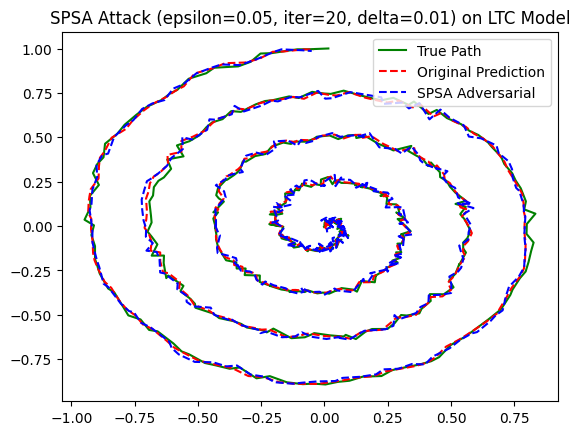

[TCN] | Original Loss: 0.002782 | Adversarial Loss: 0.004091 | Degradation: 47.0328% | Deviation: 0.876160 | Lipschitz Est.: 1.003862


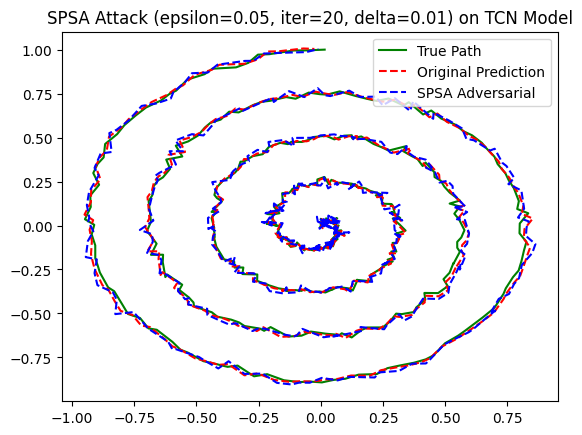

[LSTM] | Original Loss: 0.004416 | Adversarial Loss: 0.005729 | Degradation: 29.7149% | Deviation: 0.842481 | Lipschitz Est.: 0.964692


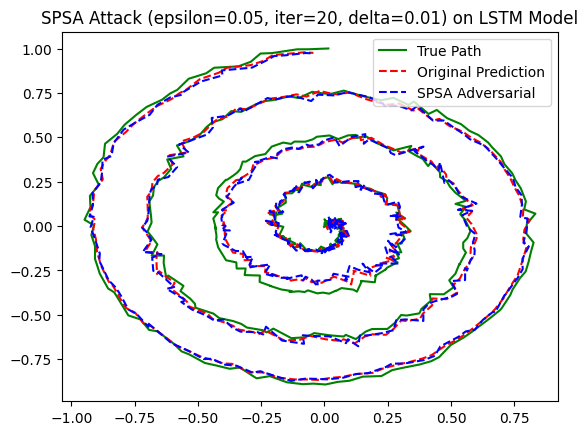

[Transformer] | Original Loss: 0.007677 | Adversarial Loss: 0.009335 | Degradation: 21.6053% | Deviation: 0.919706 | Lipschitz Est.: 1.026772


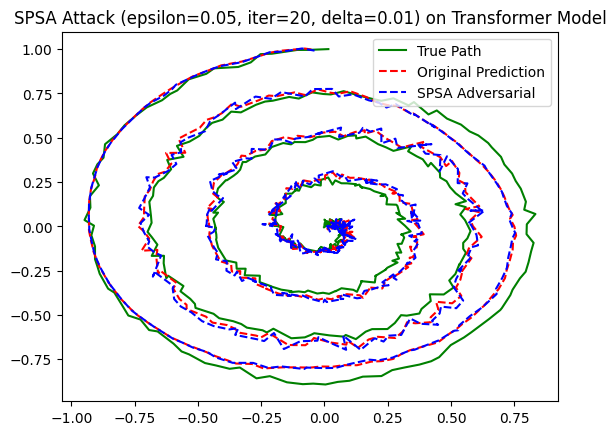

In [114]:
test_data = generate_spiral_data(400, 4, seed=SEED)
test_input = test_data[:-1]
test_target = test_data[1:]

# Run attack on LNN
run_spsa_attack(lnn_model, test_input, test_target)

# Run attack on TCN
run_spsa_attack(tcn_model, test_input, test_target)

# Run attack on LSTM
run_spsa_attack(lstm_model, test_input, test_target)

# Run attack on Transformer
run_spsa_attack(transformer_model, test_input, test_target)

# *Temporal Sensitivity Attacks*
Time-Warping Attack and Continuous-Time Adversarial Perturbation

In [115]:
# Helper function for both temporal sensitivity attacks (time-warping attack and continuous-time adversarial perturbation)
# Differentiable Linear interpolation: interpolates fp (at xp) to positions x

def torch_interp1d(x, xp, fp):
    inds = torch.searchsorted(xp, x, right=True).clamp(min=1, max=len(xp) - 1)
    x0, x1 = xp[inds - 1], xp[inds]
    f0, f1 = fp[inds - 1], fp[inds]
    slope = (f1 - f0) / (x1 - x0 + 1e-12)
    return f0 + slope * (x - x0)


# Time-Warping Attack

This function implements a time-warping adversarial attack on a liquid neural network by optimizing small perturbations to the input time grid, rather than the input values themselves. It defines a set of learnable control points that deform the time axis, then resamples the original input sequence along the warped time grid using differentiable linear interpolation. The perturbations are trained via gradient ascent to maximize the model's output error with respect to the true target, exposing the model's sensitivity to temporal distortions.

In [116]:
def run_time_warping_attack(model, input_seq, target_seq, epsilon=0.3, num_control_points=25, num_iter=50, lr=1e-2):
    model.eval()

    # Normalize input and target using the SAME training mean and std
    normalised_input_seq, _, _ = normalise(input_seq, mean, std)
    normalised_target_seq, _, _ = normalise(target_seq, mean, std)

    normalised_input_tensor = torch.FloatTensor(normalised_input_seq)
    normalised_target_tensor = torch.FloatTensor(normalised_target_seq).unsqueeze(0)

    T, D = normalised_input_tensor.shape
    time = torch.linspace(0, 1, T)
    control_x = torch.linspace(0, 1, num_control_points)
    delta_t = torch.zeros(num_control_points, requires_grad=True)

    optimizer = torch.optim.Adam([delta_t], lr=lr)
    best_adv_loss = float('-inf')
    best_adv_output_tensor = None
    best_adv_input_tensor = None

    for _ in range(num_iter):
        warped_control_y = torch.clamp(control_x + torch.clamp(delta_t, -epsilon, epsilon), 0, 1)
        warped_control_y_sorted, _ = torch.sort(warped_control_y)
        warped_time = torch_interp1d(time, control_x, warped_control_y_sorted)

        input_seq_warped = torch.stack([
            torch_interp1d(warped_time, time, normalised_input_tensor[:, d])
            for d in range(D)
        ], dim=1)

        adv_input = input_seq_warped.unsqueeze(0)
        curr_output = model(adv_input)
        loss = F.mse_loss(curr_output, normalised_target_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if loss.item() > best_adv_loss:
            best_adv_loss = loss.item()
            best_adv_output_tensor = curr_output.detach().squeeze(0)
            best_adv_input_tensor = adv_input.detach().squeeze(0)

    original_output_tensor = model(normalised_input_tensor.unsqueeze(0)).squeeze(0).detach()

    get_robustness_metrics(model, original_output_tensor, best_adv_output_tensor, normalised_input_tensor, best_adv_input_tensor, normalised_target_tensor.squeeze(0))

    # Denormalise for plotting
    adv_output, _, _ = denormalise(best_adv_output_tensor, mean, std)
    original_output, _, _ = denormalise(original_output_tensor, mean, std)

    plt.plot(target_seq[:, 0], target_seq[:, 1], 'g-', label='True Path')
    plt.plot(original_output[:, 0], original_output[:, 1], 'r--', label='Original Prediction')
    plt.plot(adv_output[:, 0], adv_output[:, 1], 'b--', label='Adversarial Prediction')
    plt.legend()

    model_names = {
            LTCRNN: "LTC",
            TCN: "TCN",
            LSTMModel: "LSTM",
            TransformerModel: "Transformer"
        }
    title = f"Time-Warping Attack (\u03b5={epsilon}, iter={num_iter}) on {model_names[type(model)]} Model"
    plt.title(title)

    plt.show()

    return

[LTC] | Original Loss: 0.002795 | Adversarial Loss: 0.046858 | Degradation: 1576.5198% | Deviation: 6.953865 | Lipschitz Est.: 0.999767


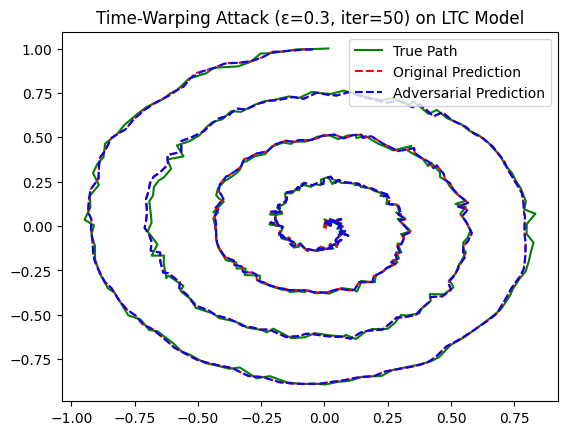

[TCN] | Original Loss: 0.002782 | Adversarial Loss: 0.049097 | Degradation: 1664.5960% | Deviation: 7.026645 | Lipschitz Est.: 1.010231


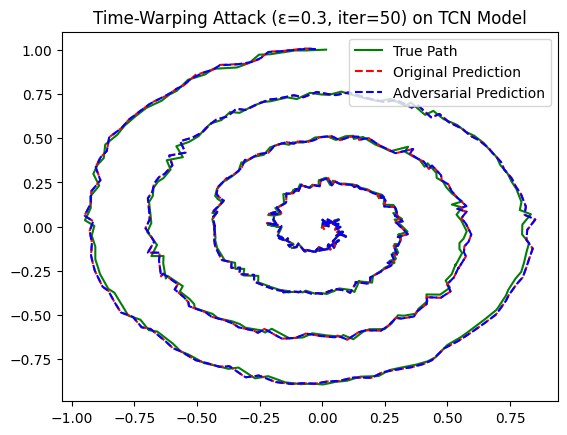

[LSTM] | Original Loss: 0.004416 | Adversarial Loss: 0.050065 | Degradation: 1033.6341% | Deviation: 6.882243 | Lipschitz Est.: 0.989470


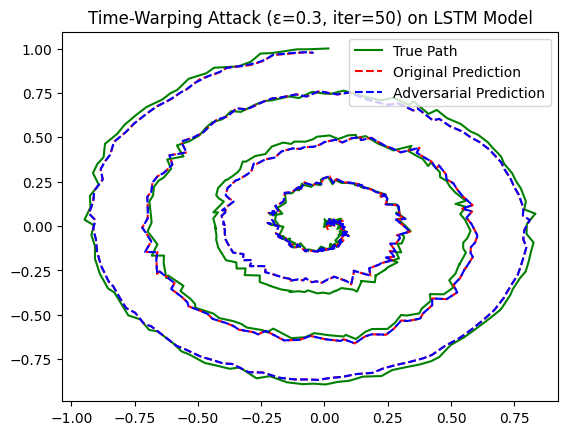

[Transformer] | Original Loss: 0.007677 | Adversarial Loss: 0.052151 | Degradation: 579.3263% | Deviation: 7.036172 | Lipschitz Est.: 1.011601


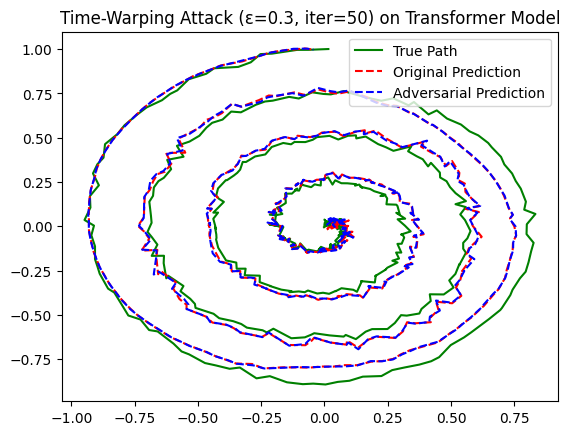

In [117]:
test_data = generate_spiral_data(400, 4, seed=SEED)
test_input = test_data[:-1]
test_target = test_data[1:]

# Run attack on LNN
run_time_warping_attack(lnn_model, test_input, test_target)

# Run attack on TCN
run_time_warping_attack(tcn_model, test_input, test_target)

# Run attack on LSTM
run_time_warping_attack(lstm_model, test_input, test_target)

# Run attack on Transformer
run_time_warping_attack(transformer_model, test_input, test_target)

# Continuous-Time Adversarial Perturbation Attack

This function implements a continuous-time adversarial perturbation attack on a liquid neural network. It defines a smooth additive perturbation function δ(t), parameterized by a small number of control points across the input time sequence. The perturbation is optimized via gradient ascent to maximize the model's output error, directly modifying the input signal over time while keeping the distortion bounded.


In [118]:
def run_continuous_time_perturbation_attack(model, input_seq, target_seq, epsilon=0.1, num_control_points=10, num_iter=50, lr=1e-2):
    model.eval()

    # Normalize input and target using the SAME training mean and std
    normalised_input_seq, _, _ = normalise(input_seq, mean, std)
    normalised_target_seq, _, _ = normalise(target_seq, mean, std)

    normalised_input_tensor = torch.FloatTensor(normalised_input_seq)
    normalised_target_tensor = torch.FloatTensor(normalised_target_seq).unsqueeze(0)

    T, D = normalised_input_tensor.shape
    time = torch.linspace(0, 1, T)
    control_x = torch.linspace(0, 1, num_control_points)

    delta_values = torch.zeros(num_control_points, D, requires_grad=True)
    optimizer = torch.optim.Adam([delta_values], lr=lr)

    best_adv_loss = float('-inf')
    best_adv_output_tensor = None
    best_adv_input_tensor = None

    for _ in range(num_iter):
        # Interpolate perturbation δ(t) over time
        perturbation = torch.stack([
            torch_interp1d(time, control_x, delta_values[:, d])
            for d in range(D)
        ], dim=1)

        perturbation = torch.clamp(perturbation, -epsilon, epsilon)
        adv_input = (normalised_input_tensor + perturbation).unsqueeze(0)

        output = model(adv_input)
        loss = F.mse_loss(output, normalised_target_tensor)

        optimizer.zero_grad()
        (-loss).backward()
        optimizer.step()

        if loss.item() > best_adv_loss:
            best_adv_loss = loss.item()
            best_adv_output_tensor = output.detach().squeeze(0)
            best_adv_input_tensor = adv_input.detach().squeeze(0)

    original_output_tensor = model(normalised_input_tensor.unsqueeze(0)).squeeze(0).detach()

    get_robustness_metrics(model, original_output_tensor, best_adv_output_tensor, normalised_input_tensor, best_adv_input_tensor, normalised_target_tensor.squeeze(0))

    # Denormalise for plotting
    adv_output, _, _ = denormalise(best_adv_output_tensor, mean, std)
    original_output, _, _ = denormalise(original_output_tensor, mean, std)

    plt.plot(target_seq[:, 0], target_seq[:, 1], 'g-', label='True Path')
    plt.plot(original_output[:, 0], original_output[:, 1], 'r--', label='Original Prediction')
    plt.plot(adv_output[:, 0], adv_output[:, 1], 'b--', label='CT Adversarial Prediction')
    plt.legend()

    model_names = {
            LTCRNN: "LTC",
            TCN: "TCN",
            LSTMModel: "LSTM",
            TransformerModel: "Transformer"
        }
    title = f"Continuous-Time Perturbation Attack (ε={epsilon}, iter={num_iter}) on {model_names[type(model)]} Model"
    plt.title(title)
    plt.show()

    return best_adv_output_tensor


[LTC] | Original Loss: 0.002795 | Adversarial Loss: 0.015616 | Degradation: 458.7058% | Deviation: 2.634408 | Lipschitz Est.: 1.011938


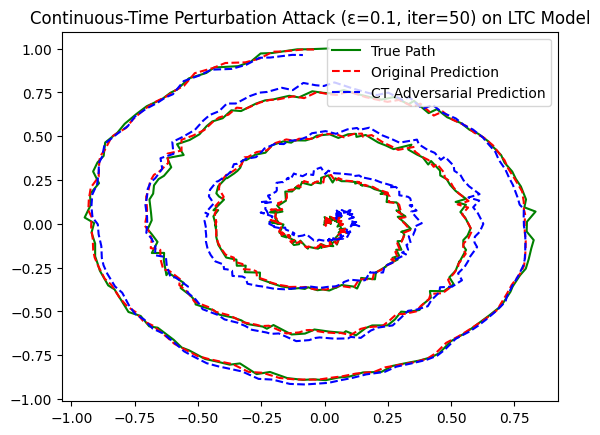

[TCN] | Original Loss: 0.002782 | Adversarial Loss: 0.014913 | Degradation: 435.9864% | Deviation: 2.599266 | Lipschitz Est.: 1.006981


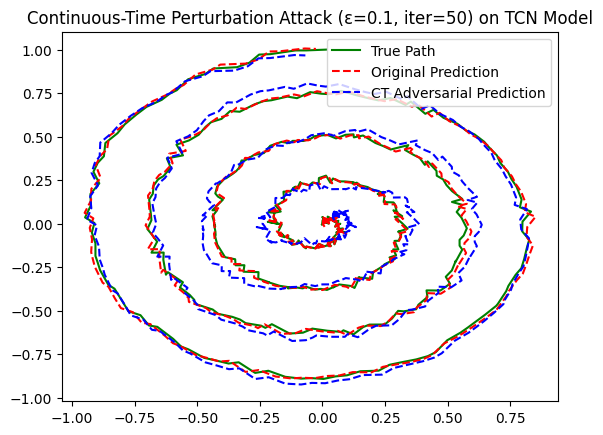

[LSTM] | Original Loss: 0.004416 | Adversarial Loss: 0.018985 | Degradation: 329.8787% | Deviation: 2.601533 | Lipschitz Est.: 1.005773


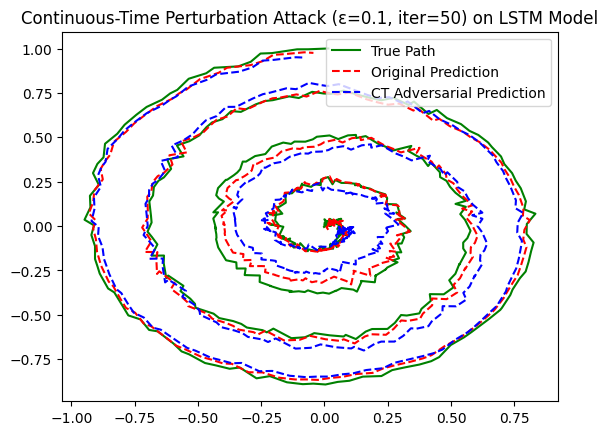

[Transformer] | Original Loss: 0.007677 | Adversarial Loss: 0.026309 | Degradation: 242.7071% | Deviation: 2.717356 | Lipschitz Est.: 1.053375


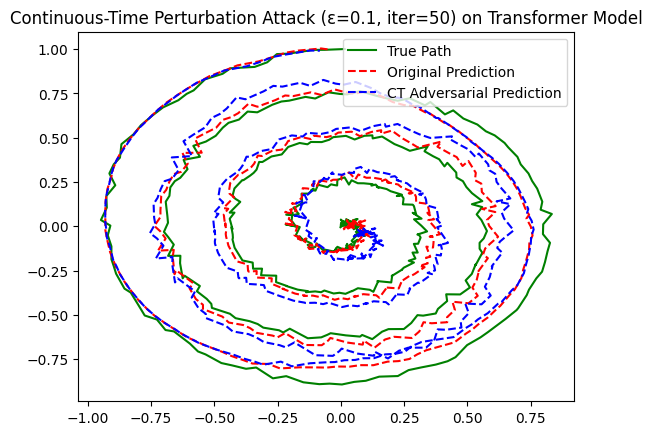

In [119]:
test_data = generate_spiral_data(400, 4, seed=SEED)
test_input = test_data[:-1]
test_target = test_data[1:]

# Run attack on LNN
adv_output_cw = run_continuous_time_perturbation_attack(lnn_model, test_input, test_target, epsilon=0.1, num_control_points=10, num_iter=50, lr=1e-2)

# Run attack on TCN
adv_output_cw = run_continuous_time_perturbation_attack(tcn_model, test_input, test_target, epsilon=0.1, num_control_points=10, num_iter=50, lr=1e-2)

# Run attack on LSTM
adv_output_cw = run_continuous_time_perturbation_attack(lstm_model, test_input, test_target, epsilon=0.1, num_control_points=10, num_iter=50, lr=1e-2)

# Run attack on Transformer
adv_output_cw = run_continuous_time_perturbation_attack(transformer_model, test_input, test_target, epsilon=0.1, num_control_points=10, num_iter=50, lr=1e-2)

# Auto LiRPA


Verifying the LNN bounds using Auto-LiRPA (https://github.com/Verified-Intelligence/auto_LiRPA/tree/master)

May have to adapt package

In [35]:
# TEMPORARY

sample_data = generate_spiral_data(500, 3, seed=SEED)

# Normalise data (both inputs and targets)
# Note - This mean and std will be used for all normalisation/denormalisation later (during inference and adversarial attacks)
sample_data, mean, std = normalise(sample_data)

all_inputs = sample_data[:-1, :]
all_targets = sample_data[1:, :]


In [72]:
# Loading in LNN model and moving model + masks to GPU

old_model = torch.load("lnn_model.pt")
state_dict = old_model.state_dict()

lnn_model = LTCRNN(wiring, input_dim, hidden_dim, output_dim)

lnn_model.load_state_dict(state_dict, strict=False)

lnn_model = lnn_model.to(device)

print("mu:", lnn_model.cell.neuron.mu.device)
print("sigma:", lnn_model.cell.neuron.sigma.device)
print("sparsity_mask:", lnn_model.cell.neuron.sparsity_mask.device)
print("sensory_sparsity_mask:", lnn_model.cell.neuron.sensory_sparsity_mask.device)


mu: cuda:0
sigma: cuda:0
sparsity_mask: cuda:0
sensory_sparsity_mask: cuda:0


In [73]:
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seq_len = 3
torch.manual_seed(SEED)
dummy_input = torch.randn(1, all_inputs.shape[0], all_inputs.shape[1]).to(device) # Initialising a dummy input with correct dimensions for the BoundedModule
lnn_model = lnn_model.to(device)
bounded_model = BoundedModule(lnn_model, dummy_input)

input_tensor = torch.FloatTensor(all_inputs).unsqueeze(0).to(device)

ptb = PerturbationLpNorm(norm=np.inf, eps=0.1)
bounded_input = BoundedTensor(input_tensor, ptb)
bounded_prediction = bounded_model(bounded_input)

# Possible Method values (working):
#   "IBP" (Interval Bound Propagation: fast and conservative; propagates min/max only. Very stable, works with most models but gives loose bounds)
#   "CROWN-IBP" (Hybrid of CROWN and IBP: uses IBP for early layers, CROWN for later ones. Good balance of stability and tightness)
# Method values (not working):
#   "CROWN" (Convex Relaxation of Neural Networks: builds piecewise linear relaxations. Tighter than IBP, often more stable than backward)
#   "forward"
#   "backward" (Full backward bound propagation using dual variables. Tighter bounds but slower and can crash)

lb, ub = bounded_model.compute_bounds(x=(bounded_input,), method="IBP")

# Denormalise bounds
# lb_denorm, _, _ = denormalise(lb.detach().numpy(), mean, std)
# ub_denorm, _, _ = denormalise(ub.detach().numpy(), mean, std)
lb_denorm, _, _ = denormalise(lb.detach().cpu().numpy(), mean, std)
ub_denorm, _, _ = denormalise(ub.detach().cpu().numpy(), mean, std)

print(lb_denorm.shape, ub_denorm.shape)
print(lb_denorm[:3])

(1, 499, 2) (1, 499, 2)
[[[-5.74550040e-02 -6.18809024e-02]
  [-7.35486932e-02 -6.40750863e-02]
  [-7.07559360e-02 -9.12128993e-02]
  [-6.14816186e-02 -7.83725815e-02]
  [-7.74166388e-02 -8.34797656e-02]
  [-7.81254657e-02 -8.15944653e-02]
  [-5.96818073e-02 -8.08857905e-02]
  [-6.51427987e-02 -8.17604582e-02]
  [-7.59772500e-02 -7.13781750e-02]
  [-6.60161726e-02 -7.57590373e-02]
  [-7.30415544e-02 -6.52800312e-02]
  [-7.20644481e-02 -6.42168908e-02]
  [-6.35713668e-02 -6.50822957e-02]
  [-8.22813789e-02 -6.95948209e-02]
  [-8.01565944e-02 -6.61310048e-02]
  [-6.59196662e-02 -5.24107838e-02]
  [-6.68739553e-02 -5.11422499e-02]
  [-5.27809472e-02 -6.46706299e-02]
  [-6.09763236e-02 -5.68941903e-02]
  [-6.36759345e-02 -4.78806542e-02]
  [-3.69030034e-02 -6.93049207e-02]
  [-4.72860100e-02 -5.35699697e-02]
  [-4.33785674e-02 -6.04334943e-02]
  [-5.31350625e-02 -5.06009775e-02]
  [-4.42771004e-02 -6.08471310e-02]
  [-3.68175519e-02 -7.38903527e-02]
  [-4.50260967e-02 -7.50715181e-02]
  [-

In [76]:
lb_denorm[0][:3]

array([[-0.057455  , -0.0618809 ],
       [-0.07354869, -0.06407509],
       [-0.07075594, -0.0912129 ]])

In [69]:
print(torch.cuda.memory_allocated() / 1024**2, "MB allocated")
print(torch.cuda.memory_reserved() / 1024**2, "MB reserved")

11.7314453125 MB allocated
12.0 MB reserved


In [42]:
# Save computed bounds (long computation time for bounded_model.compute_bounds)

torch.save({
    'lb': lb.cpu(),
    'ub': ub.cpu(),
    'lb_denormalised': lb_denorm,
    'ub_denormalised': lb_denorm,
    'model_state_dict': lnn_model.state_dict(),
    'input_shape': list(input_tensor.shape),
    'all_inputs': torch.FloatTensor(all_inputs),
    'input_tensor': input_tensor.cpu(),
    'normalisation': {
        'mean': mean.tolist(),
        'std': std.tolist()
        },
    'eps': 0.1,
    'method': 'IBP'
    },
    'lnn_bounds_raw.pt')

# Then to load back in:

# checkpoint = torch.load('lnn_bounds_raw.pt')

# lb = checkpoint['lb']
# ub = checkpoint['ub']
# lb_denorm = checkpoint['lb_denormalised']
# ub_denorm = checkpoint['ub_denormalised']

# all_inputs = checkpoint['all_inputs']
# input_tensor = checkpoint['input_tensor']
# input_shape = checkpoint['input_shape']

# lnn_model.load_state_dict(checkpoint['model_state_dict'])

# mean = torch.tensor(checkpoint['normalisation']['mean'])
# std = torch.tensor(checkpoint['normalisation']['std'])

# eps = checkpoint['eps']
# method = checkpoint['method']

# dummy_input = torch.randn(*input_shape)
# bounded_model = BoundedModule(lnn_model, dummy_input)




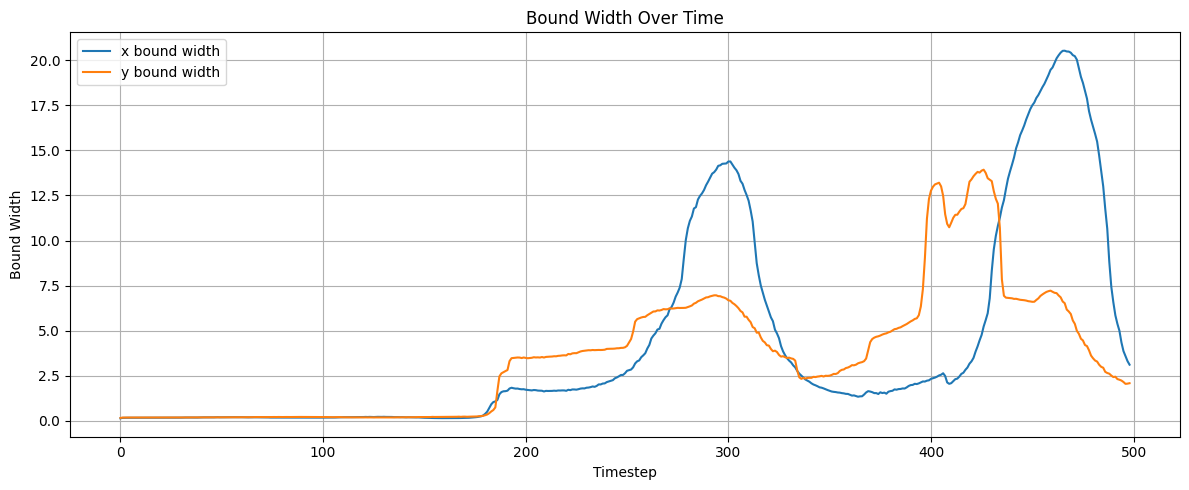

In [77]:
# Visualise bound widths over time

bound_width = ub_denorm.squeeze(0) - lb_denorm.squeeze(0)  # shape: (499, 2)
bound_width_np = bound_width

plt.figure(figsize=(12, 5))
plt.plot(bound_width_np[:, 0], label='x bound width')
plt.plot(bound_width_np[:, 1], label='y bound width')
plt.xlabel('Timestep')
plt.ylabel('Bound Width')
plt.title('Bound Width Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Plot explanation: The plot shows the bound width over time for the x and y components of the LNN's output under input perturbations, as computed using interval bound propagation. Throughout most of the sequence, the bound widths remain low, indicating that the model's predictions are robust and stable with respect to small input changes. However, there is a noticeable spike in the x bound width near the end of the sequence, suggesting a localized drop in robustness and higher sensitivity to perturbations in that region. This may be due to increased curvature, state instability, or a lack of training coverage in the corresponding region of the spiral. Overall, the LNN demonstrates strong robustness across the majority of the sequence, with only transient vulnerabilities